# Capture traces for 2.12

#### Try-out

In [ ]:
!pip install ipython ipympl ipywidgets -Uq
!pip install --upgrade ipython -Uq

In [1]:
import matplotlib.pylab as plt

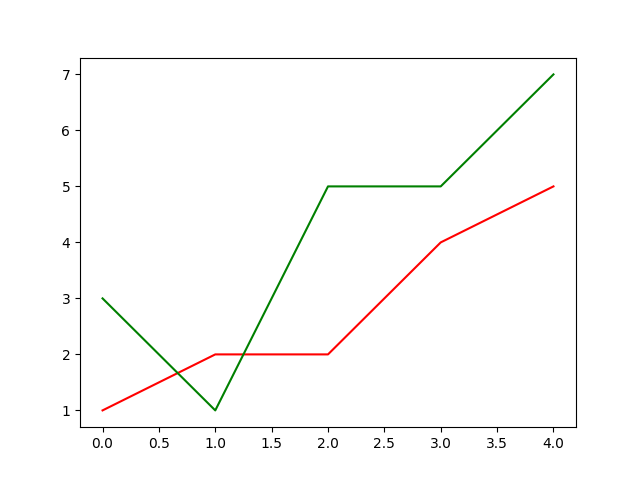

In [2]:
%matplotlib ipympl
import matplotlib.pylab as plt
    
plt.plot([1,2,2,4,5], 'r')
plt.plot([3,1,5,5,7], 'g')
plt.show()

#### Agregates

In [1]:
import matplotlib.pyplot as plt

In [2]:
%run "./File_Uploader.ipynb"


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\Samuel\AppData\Local\Temp\ipykernel_11028\4114886631.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [3]:
%run "./ANN_Observer.ipynb"

✔️ The Setuper class succesfuly imported.
✔️ The ANN_Observer class succesfuly imported.


In [77]:
%run "./Analyser.ipynb"

✔️ The Analyser succesfuly runned.


#### Definitions

In [8]:
scope : cw.scope = None
target: cw.target = None
cw_setuper: CW_Setuper
def setup(makedir):
    global scope
    global target
    global cw_setuper
    make_dir = makedir
    re_init_config = {"MAKEDIR" : f'./{make_dir}/'}
    cw_setuper = CW_Setuper(firmware_reinit = True, re_init_dict  = re_init_config)
    scope = cw_setuper.scope
    target = cw_setuper.target
    return scope, target, cw_setuper

In [75]:
def calc_corr(waves, rand_inputs, _func, _name, epochs, trace_len):
    ncorr_all1 = _func(rand_inputs, np.array(waves)[:,:], n_traces = epochs, trace_len = trace_len, ith_weight = 0, calc_p_value=False)
    np.save(f"E:/DP_database/database/corrs_{_name}.npy", np.array(ncorr_all1))
    plot_mult(np.array(ncorr_all1)[:,:], _type = "tmp")

In [113]:
def capture_correlate(scope, epochs_list = [3000], ncorr_all1 = None, ncorr_all2 = None, decimate = 1, reverse = False, runName="_722_BasicMLP"):
    for i in trange(len(epochs_list), desc='Capturing and Analysing the traces:'):
        global epochs
        epochs = epochs_list[i]
        cmd = 'p'
        if reverse:
            cmd = 'o'
        name = f"{runName}_Dec{decimate}-ntg{decimate}-{epochs}" #ntg no-target-reset
     
        scope_setup(samples=24429, decimate=decimate)    
        traces, rand_inputs = measure_traces(cmd=cmd)
        waves = []
        out_data = []
        for i in traces:
            waves.append(i[0])
            out_data.append(i[2])
        plot_mult(np.array(waves[0]), _type = name, mult=False)
        files = save_data(waves, rand_inputs, out_data[0], path="E:/DP_database/database", name_extended = name)
        #upload_file_to_gdrive(files,  dir_path = "E:/DP_database/database/")
        #Analysis
        print(out_data[0])
        ith_weight = 0
        start = ith_weight*epochs
        ncorr_all1 = V2_ANN_CPA_OTS(rand_inputs, np.array(waves)[:,:], n_traces = epochs, trace_len = 24000, ith_weight = 0, calc_p_value=False)
        np.save(f"E:/DP_database/database/corrs_{name}.npy", np.array(ncorr_all1))
        plot_mult(np.array(ncorr_all1)[:,:], _type = "tmp")
        
        ncorr_all2 = oldV2_ANN_CPA_OTS(rand_inputs, np.array(waves)[:,:], n_traces = epochs, trace_len = 24000, ith_weight = 0, calc_p_value=False)
        np.save(f"E:/DP_database/database/corrs2_{name}.npy", np.array(ncorr_all2))
        plot_mult(np.array(ncorr_all2)[:,:], _type = "tmp")
    cw_setuper._scope_disc_()
    scope : cw.scope = None
    target: cw.target = None
    return ncorr_all1, ncorr_all2, rand_inputs, waves, out_data[0]

In [50]:
def analyse_corr(corr_map: np.ndarray, weights: list[int], stop_num = 5, maxims_map = None, _index = 0, peak_range = 0.3, show_info=True, mountain_half_dist = 5, level = 3):
    index = _index
    for secret in weights:
        secret_value, time_sample, correlation, localMax_vector, colmn_maxVector, nextIndex, maxims_map = get_weight(corr_map,
                                                                                                                     peak_range,
                                                                                                                     show_info=True,
                                                                                                                     lastIndex=index,
                                                                                                                     map_2dgrMaxs=maxims_map,
                                                                                                                     mountain_half_dist=mountain_half_dist,
                                                                                                                     level=level)
    
        index = nextIndex
        figure, axis = plt.subplots(1, 2)
        # Comparison to real correlation
        axis[0].plot(colmn_maxVector, color='b', label='agregate_of_maxs_corrs', linewidth=0.5)
        axis[0].plot(corr_map[secret], color='g', label=f'secret_val_corr = {secret}', linewidth=0.5)
        #axis[0].legend(loc='upper right')
        axis[0].legend(bbox_to_anchor=(0.75, 1.15), ncol=2)
        axis[0].set_title("All - Real")
        plt.xlabel("Time Sample")
        plt.ylabel("Correlation")
        plt.axvline(x = index, color = 'orange')
    
        # Comparison to found correlation
        axis[1].plot(colmn_maxVector, color='b', label='agregate_of_maxs_corrs', linewidth=0.5)
        axis[1].plot(corr_map[secret_value], color='r', label=f'found_corr = {secret_value}', linewidth=0.5)
        #axis[1].legend(loc='upper right')
        axis[1].legend(bbox_to_anchor=(0.75, -0.5), ncol=2)
        axis[1].set_title("All - Found")
        plt.axvline(x = index, color = 'orange')
    
        #figure.savefig(f'{name}_correlation.png')
    
        stop_num -= 1
        if stop_num == 0:
            break
        plt.show()
        last_found_indx = time_sample

## Capture Traces

## Zkonstatovanie: 

- Po vypnuti Optimalizacie u ANN, vysledne korelacne matice uz boli vierohodnejsie, dalej my ostava odskusat, ci problem je v metode vypoctu korelacie, alebo v pretipovani na uintX_t

### QUANTIZATED MULT CPA, tryout with 2 similar but different CPA algs. 

In [116]:
scope, target, cw_setuper = setup("makefile_dir_basic_quantized_mult")
time.sleep(30)

⚠️ Changed, firmware config!!!
✔️ Firmware maked, with command cd %s | make CRYPTO_TARGET=%s PLATFORM=%s FIRMWAREPATH=%s SS_VER=%s TARGET=%s> output.txt 2>warnings_new.txt.
INFO: Found ChipWhisperer😍
✔️ INFO: Scope and Target, are set😍
❤️ Target hex: ./makefile_dir_basic_quantized_mult/simpleserial-target-CWLITEARM.hex
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 11259 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 11259 bytes
✔️ Setuper initiated.


Capturing and Analysing the traces::   0%|          | 0/1 [00:00<?, ?it/s]

⚠️ Generating rand_input..


                                Capturing traces:   0%|          | 0/3000 [00:00<?, ?it/s]

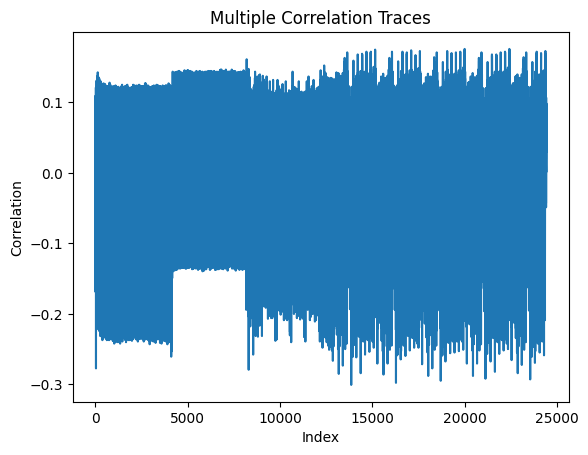

✔️ Saving Rand_input succesfull.
🌍 Saving Secret_weights succesfull.
CWbytearray(b'00 72 02 05 00 af 00')


Calculating Correlations for the Secret-Key:   0%|          | 0/256 [00:00<?, ?it/s]

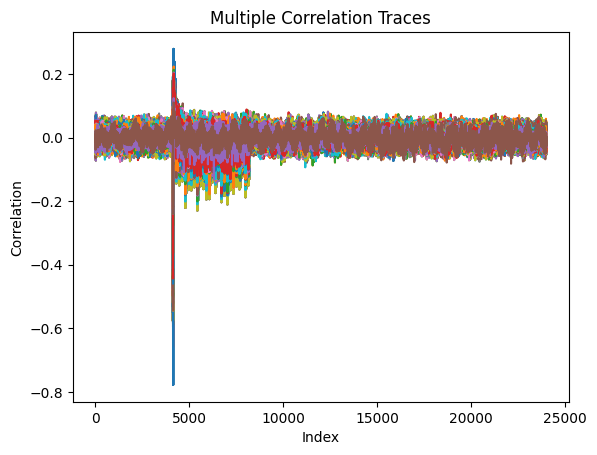

Calculating Correlations for the Secret-Key:   0%|          | 0/256 [00:00<?, ?it/s]

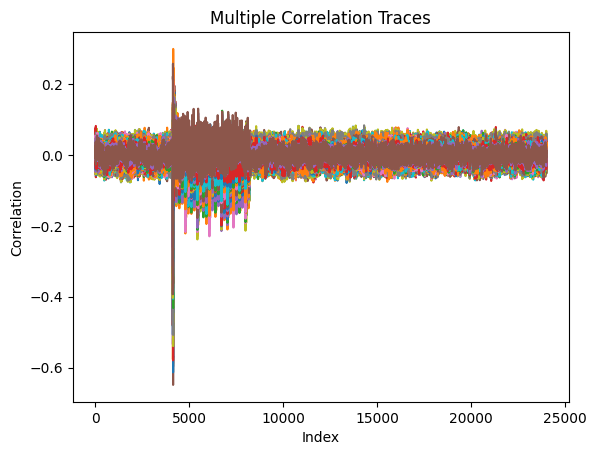

✔️ Scope disconnected.
✔️ Firmware disconnected.


In [117]:
corr1, corr2, rand_input, waves, out = capture_correlate(scope, epochs_list = [3000], ncorr_all1 = None, ncorr_all2 = None, decimate = 1, reverse = True, runName="_722_BasicMult")

Calculating Correlations for the Secret-Key:   0%|          | 0/256 [00:00<?, ?it/s]

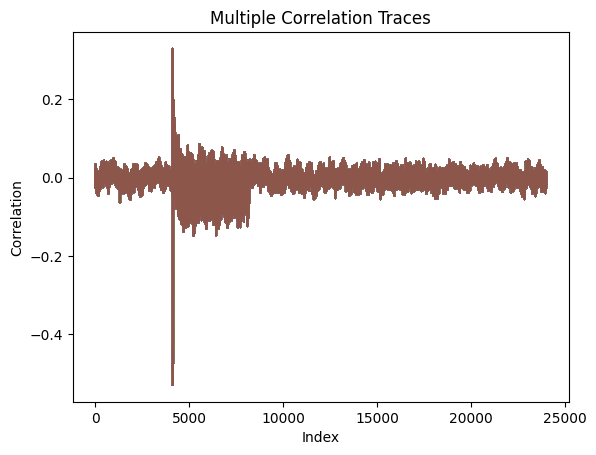

In [120]:
calc_corr(waves=waves, rand_inputs=rand_input, _func=ancientV2_ANN_CPA_OTS, _name="tmp_corr", epochs=3000, trace_len=24000)

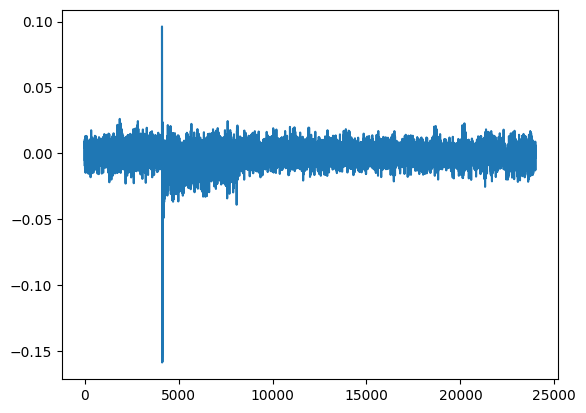

In [134]:
plt.plot(np.subtract(abs(np.array(corr2)[5,:]), abs(np.array(corr1)[10,:])))

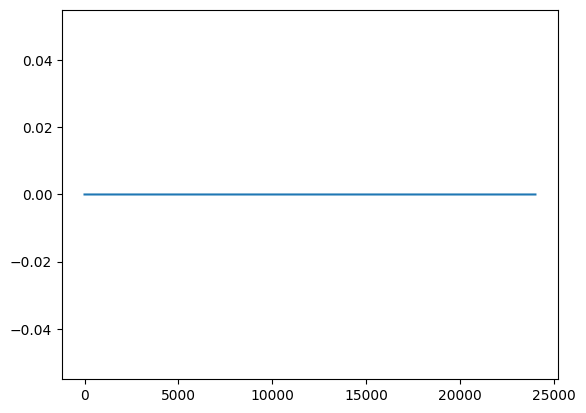

In [127]:
plt.plot(np.subtract(abs(np.array(corr1)[5,:]), abs(np.array(corr1)[160,:])))

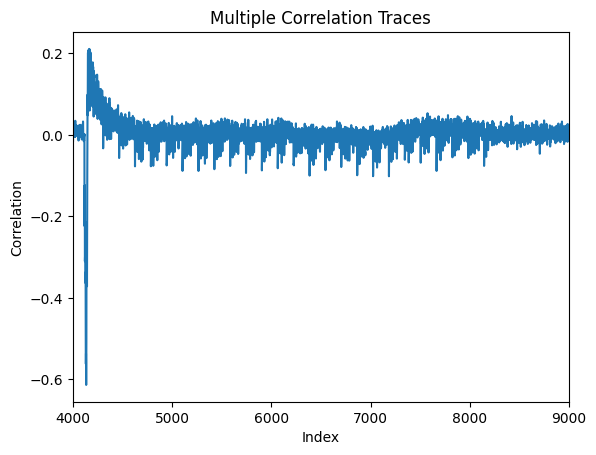

In [131]:
plot_mult(np.array(corr2)[10,:], _type = "tmp", mult=False, xlim=[4000,9000])

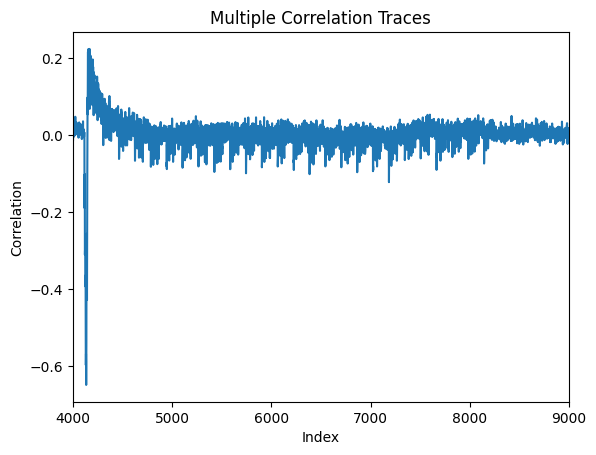

In [130]:
plot_mult(np.array(corr2)[5,:], _type = "tmp", mult=False, xlim=[4000,9000])

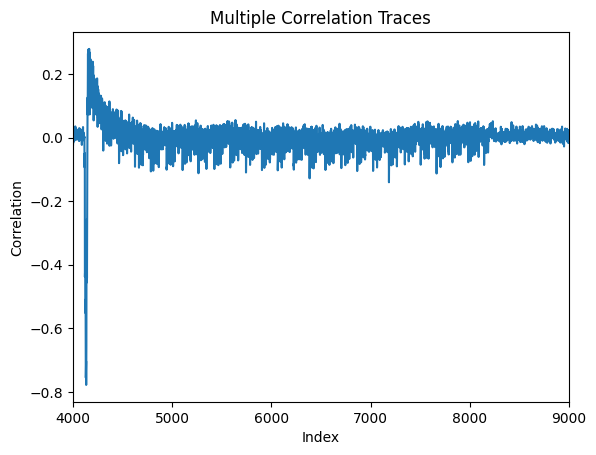

In [121]:
plot_mult(np.array(corr1)[5,:], _type = "tmp", mult=False, xlim=[4000,9000])

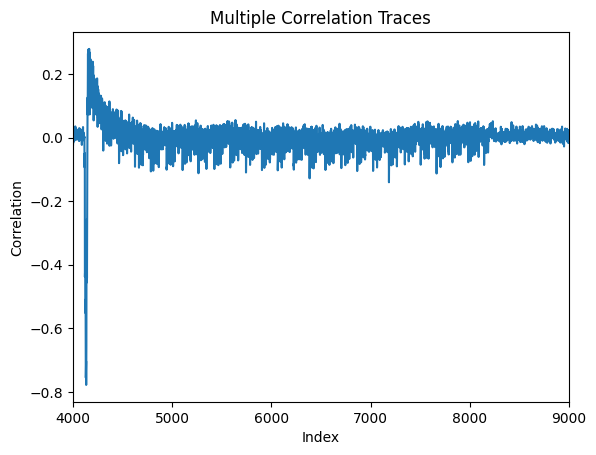

In [122]:
plot_mult(np.array(corr1)[10,:], _type = "tmp", mult=False, xlim=[4000,9000])

In [119]:
corr_map = abs(np.array(corr1)[:,:])
analyse_corr(corr_map=corr_map, weights=np.array(out)[3:-4], stop_num = 5, maxims_map = None,
                 _index = 0, peak_range = 0.3, show_info=True, mountain_half_dist = 5, level = 3)

### QUANTIZATED ANN CPA, tryout with 2 similar but different CPA algs., and turned off optimalization while building 

In [19]:
scope.dis()
target.dis()

In [20]:
scope, target, cw_setuper = setup("makefile_dir_basic_quantized_MLP-NO_OPT")
time.sleep(10)

⚠️ Changed, firmware config!!!
✔️ Firmware maked, with command cd %s | make CRYPTO_TARGET=%s PLATFORM=%s FIRMWAREPATH=%s SS_VER=%s TARGET=%s> output.txt 2>warnings_new.txt.
INFO: Found ChipWhisperer😍
✔️ INFO: Scope and Target, are set😍
❤️ Target hex: ./makefile_dir_basic_quantized_MLP-NO_OPT/simpleserial-target-CWLITEARM.hex
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 22843 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 22843 bytes
✔️ Setuper initiated.


Capturing and Analysing the traces::   0%|          | 0/1 [00:00<?, ?it/s]

⚠️ Generating rand_input..


                                Capturing traces:   0%|          | 0/3000 [00:00<?, ?it/s]

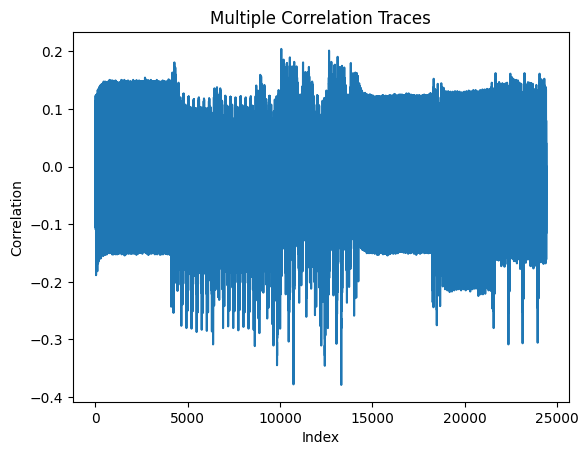

✔️ Saving Rand_input succesfull.
🌍 Saving Secret_weights succesfull.
CWbytearray(b'00 72 16 0a 00 00 00 00 00 00 00 14 00 00 00 00 00 00 00 4d d2 25 55 2a 00 50 00')


Calculating Correlations for the Secret-Key:   0%|          | 0/256 [00:00<?, ?it/s]

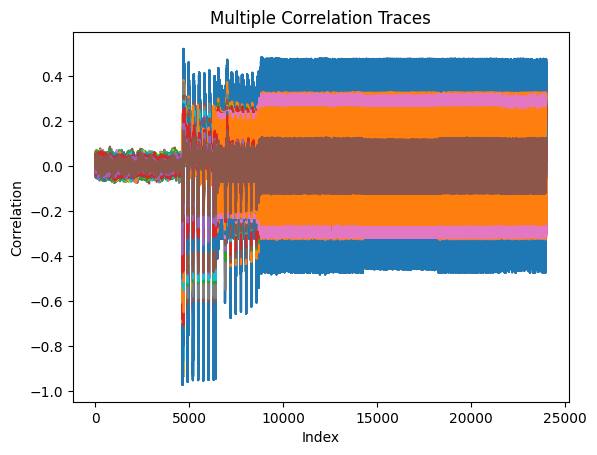

Calculating Correlations for the Secret-Key:   0%|          | 0/256 [00:00<?, ?it/s]

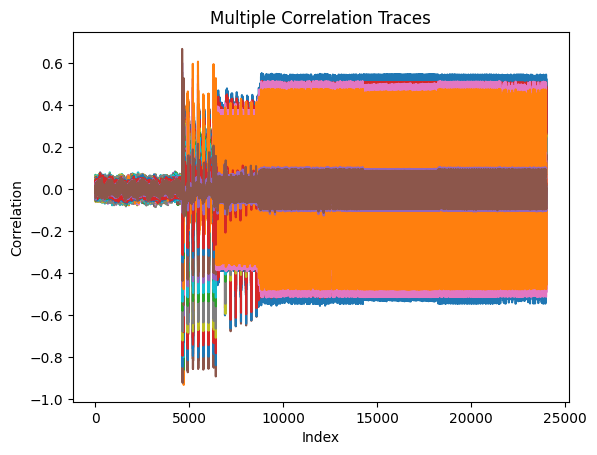

✔️ Scope disconnected.
✔️ Firmware disconnected.


In [21]:
corr1, corr2, rand_input, waves, out = capture_correlate(scope, epochs_list = [3000], ncorr_all1 = None, ncorr_all2 = None, decimate = 1, reverse = False, runName="_722_BasicMLP-NO_OPT")

Calculating Correlations for the Secret-Key:   0%|          | 0/256 [00:00<?, ?it/s]

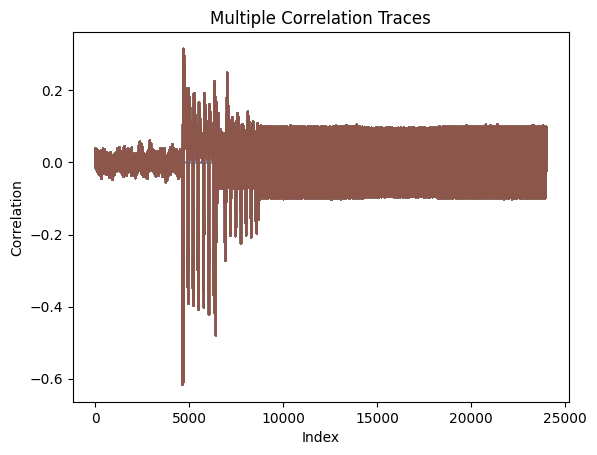

In [81]:
calc_corr(waves=waves, rand_inputs=rand_input, _func=ancientV2_ANN_CPA_OTS, _name="tmp_corr", epochs=3000, trace_len=24000)

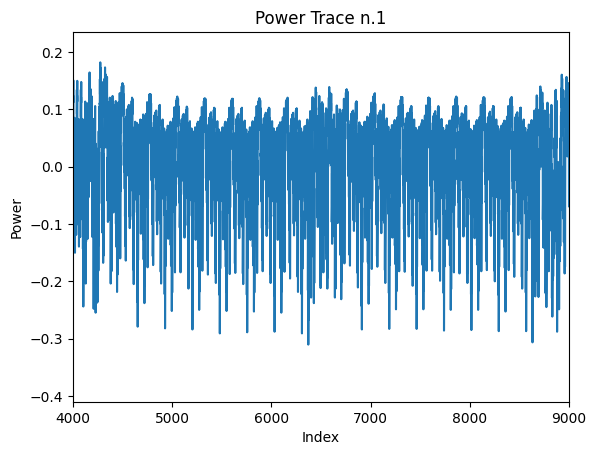

In [70]:
plot_mult(np.array(waves)[1,:], _type = "tmp", mult=False,  xlim=[4000,9000], graph_title="Power Trace n.1", ylabel="Power")

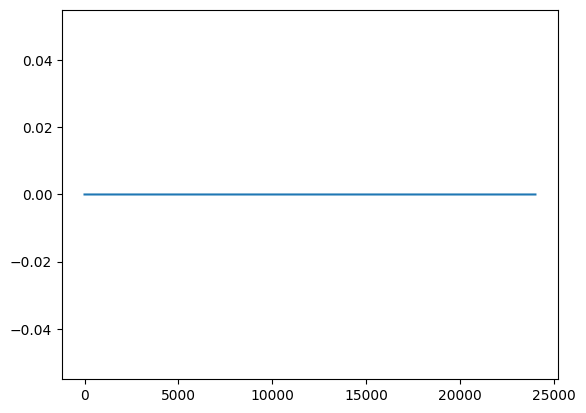

In [112]:
plt.plot(np.subtract(abs(np.array(corr1)[5,:]), abs(np.array(corr1)[10,:])))

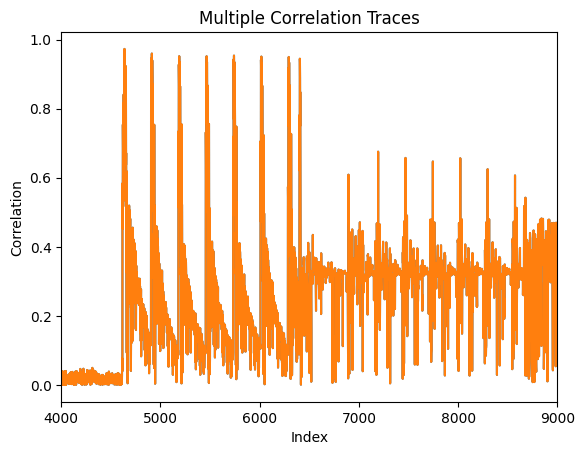

In [99]:
plot_mult(abs(np.array(corr1)[[5, 10],:]), _type = "tmp", mult=True, xlim=[4000,9000])

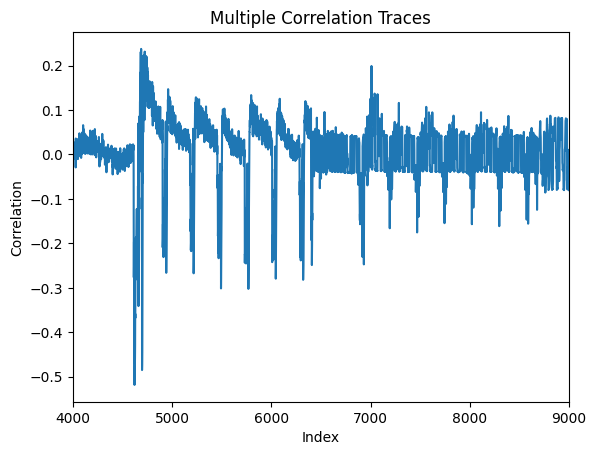

In [104]:
plot_mult(np.array(corr1)[3,:], _type = "tmp", mult=False, xlim=[4000,9000])

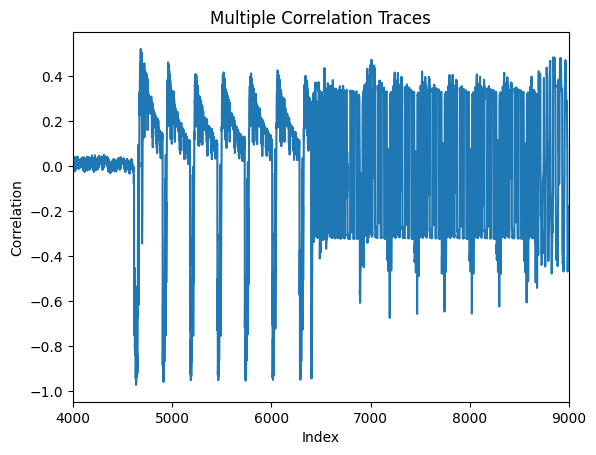

In [84]:
plot_mult(np.array(corr1)[5,:], _type = "tmp", mult=False, xlim=[4000,9000])

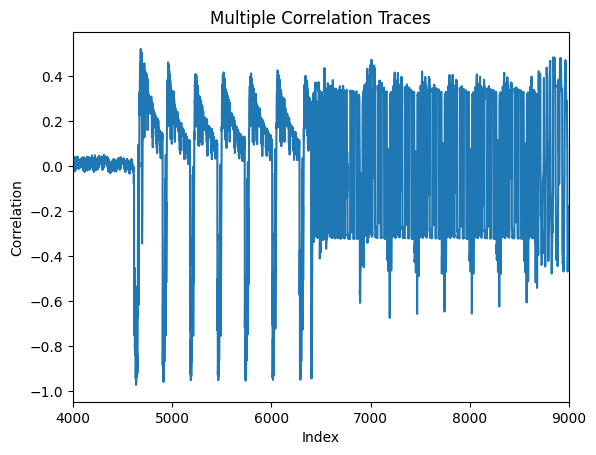

In [82]:
plot_mult(np.array(corr1)[10,:], _type = "tmp", mult=False, xlim=[4000,9000])

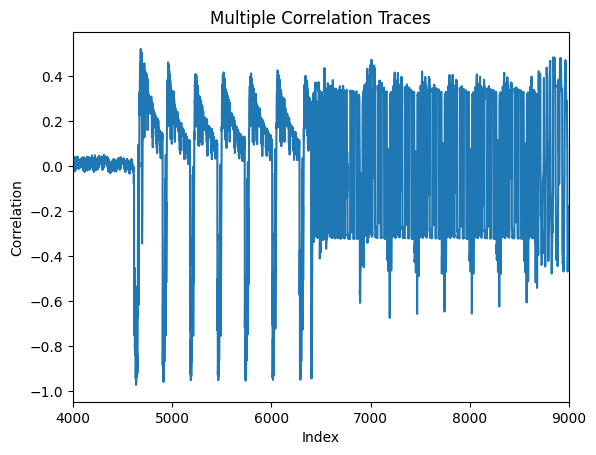

In [83]:
plot_mult(np.array(corr1)[20,:], _type = "tmp", mult=False, xlim=[4000,9000])

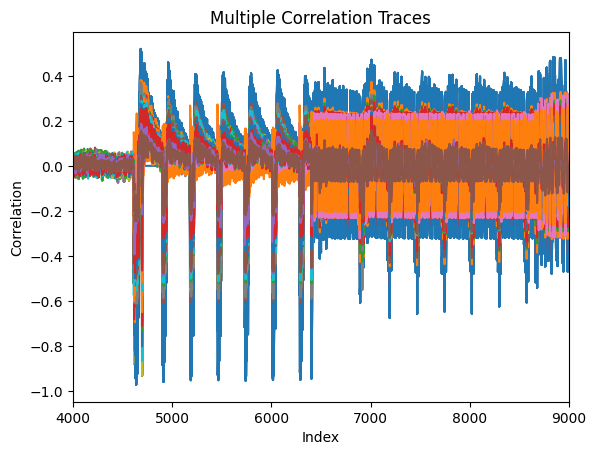

In [63]:
plot_mult(np.array(corr1)[:,:], _type = "tmp", mult=True, xlim=[4000,9000])

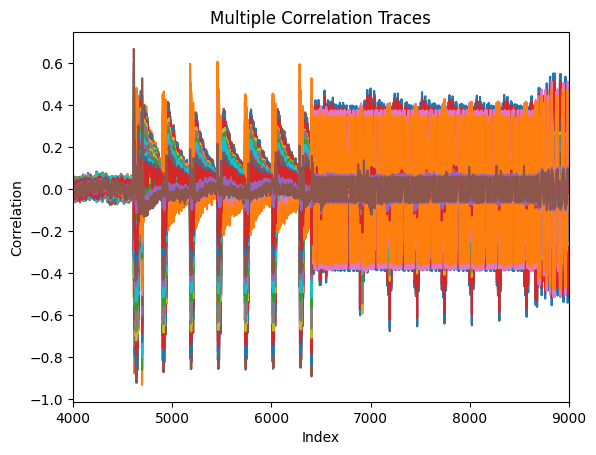

In [71]:
plot_mult(np.array(corr2)[:,:], _type = "tmp", mult=True, xlim=[4000,9000])

In [43]:
np.array(out)[3:-4]

array([ 10,   0,   0,   0,   0,   0,   0,   0,  20,   0,   0,   0,   0,
         0,   0,   0,  77, 210,  37,  85], dtype=uint8)

12488
 Index of global max: 4697 and global_max_val: 0.9324396229778797


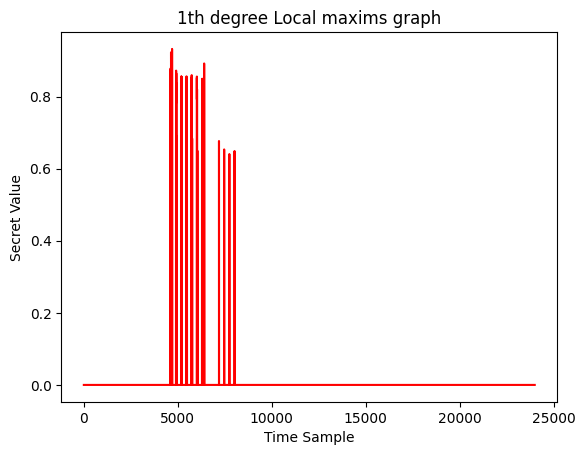

Number of uniques: 3
Number of local maxims: 124
Uniquess: [255, 1, 5]
Local maxims: [255, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


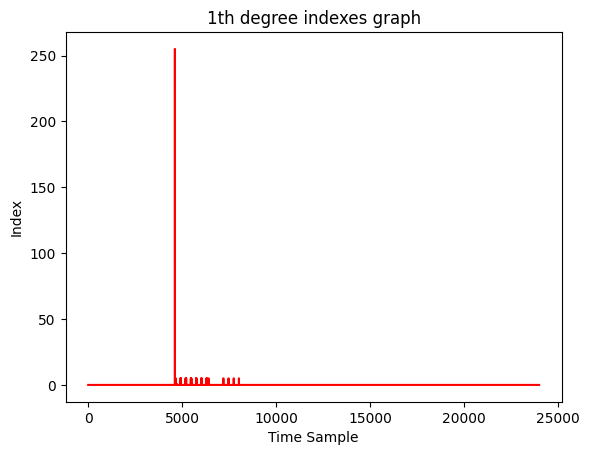

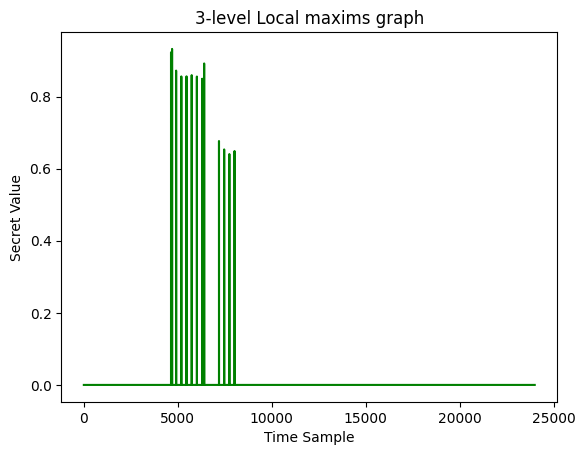

Number of uniques: 2
Number of local maxims: 13
Uniquess: [5, 1]
Local maxims: [5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


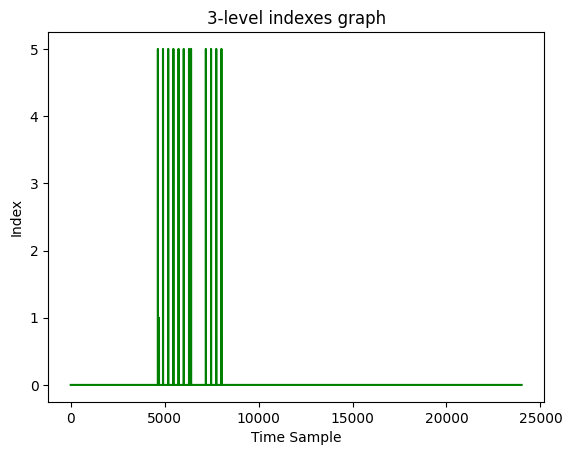

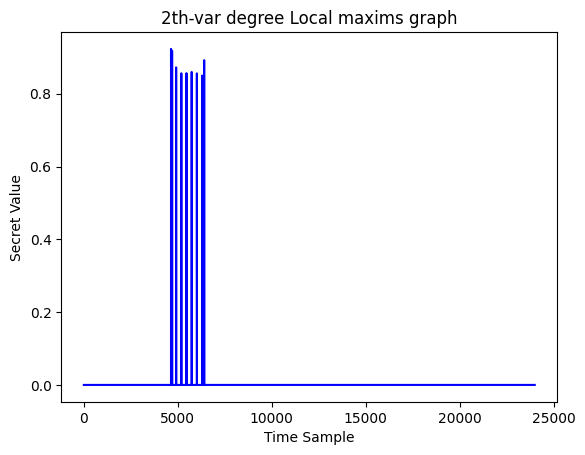

Number of uniques: 2
Number of local maxims: 9
Uniquess: [5, 1]
Local maxims: [5, 1, 5, 5, 5, 5, 5, 5, 5]


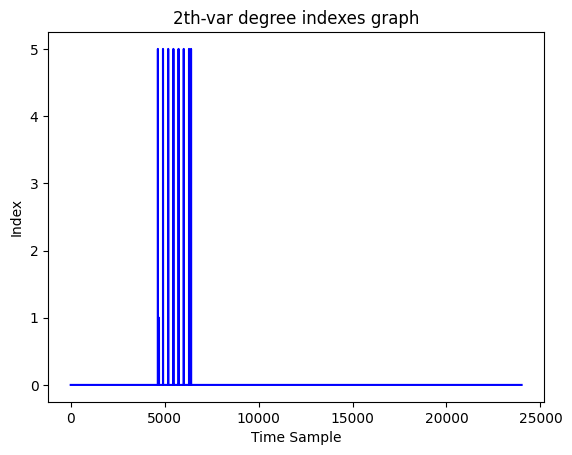

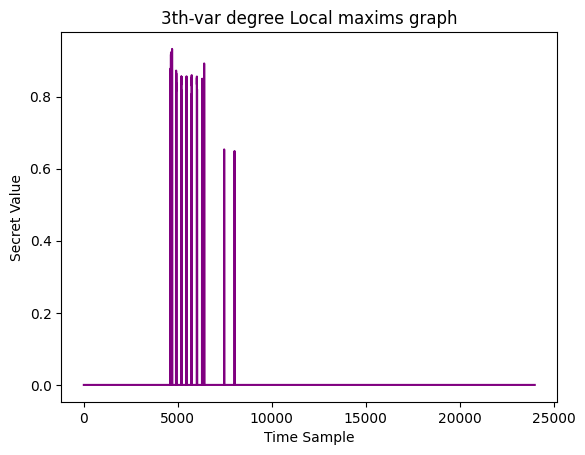

Number of uniques: 2
Number of local maxims: 84
Uniquess: [1, 5]
Local maxims: [1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


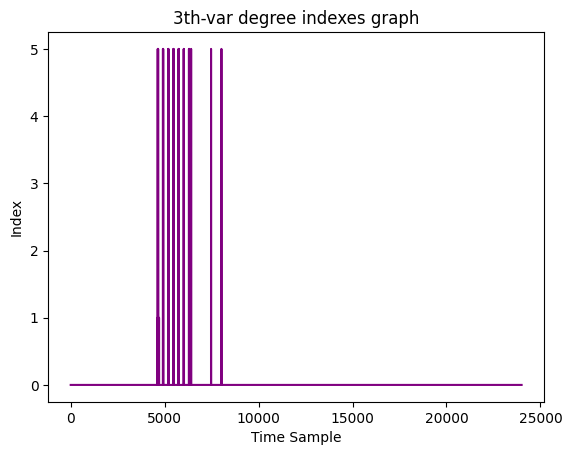

In range 0 - 24000
 Found the soonest secret value is 5, at the time sample 4641, with correlation secret_corr = 0.923


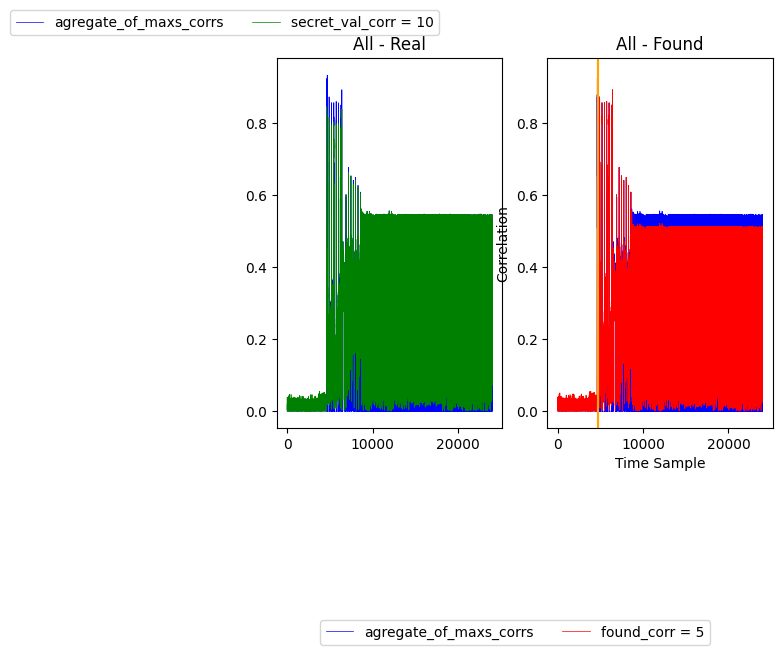

In range 4670 - 24000
 Found the soonest secret value is 1, at the time sample 4698, with correlation secret_corr = 0.918


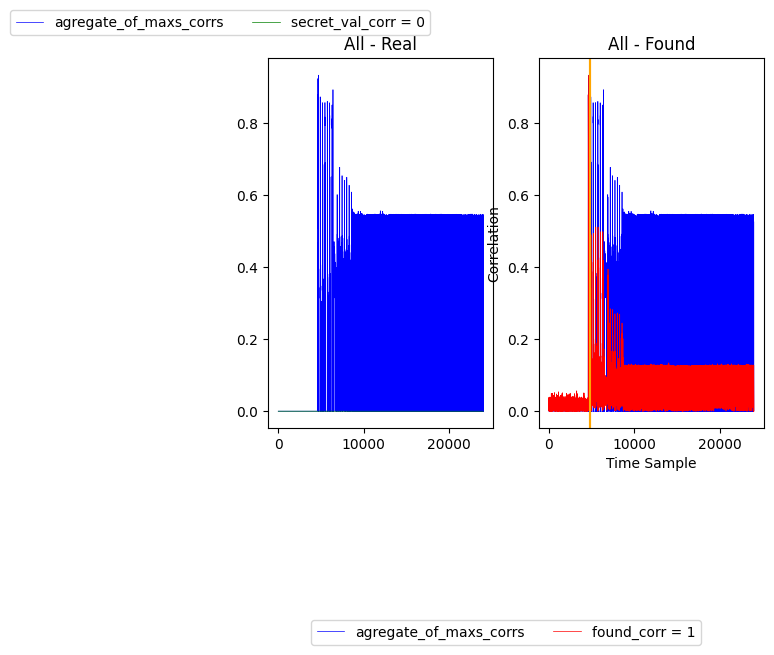

In range 4805 - 24000
 Found the soonest secret value is 5, at the time sample 4913, with correlation secret_corr = 0.872


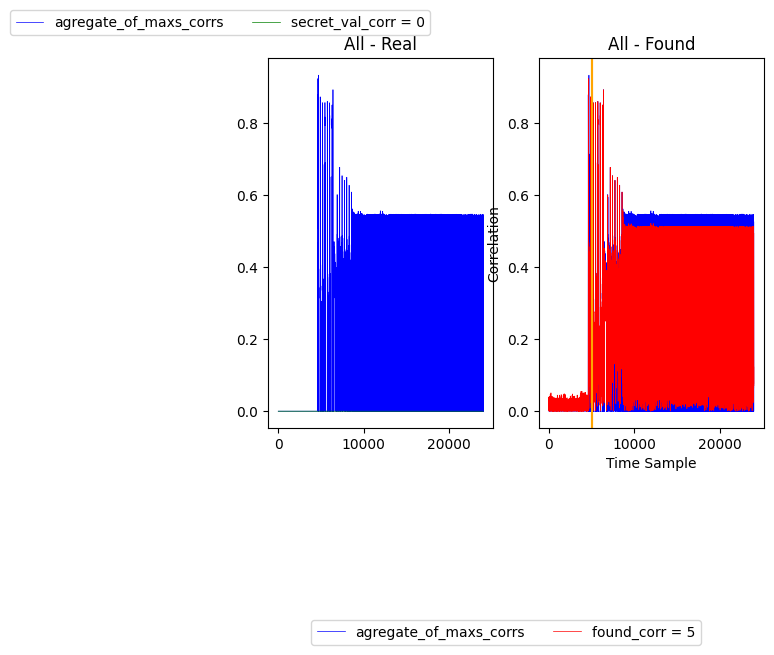

In range 5051 - 24000
 Found the soonest secret value is 5, at the time sample 5189, with correlation secret_corr = 0.856


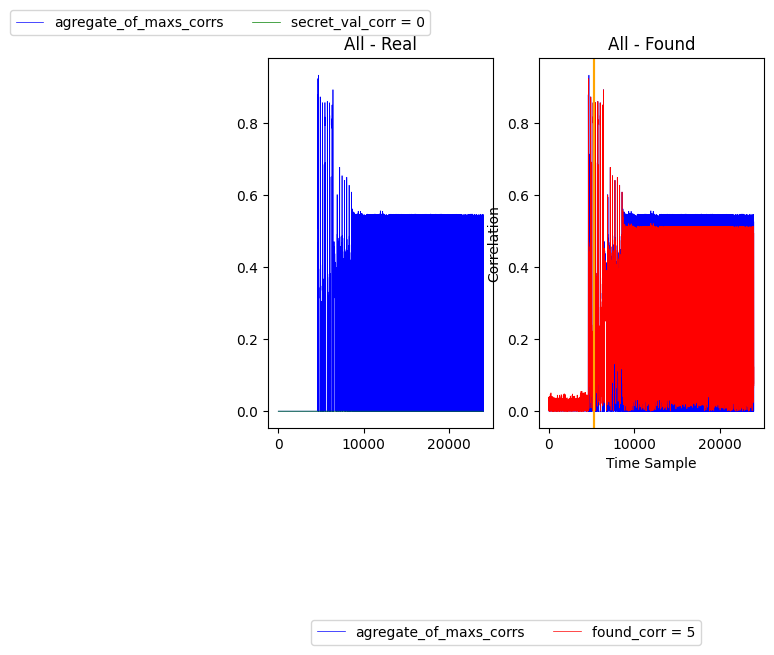

In range 5327 - 24000
 Found the soonest secret value is 5, at the time sample 5465, with correlation secret_corr = 0.856


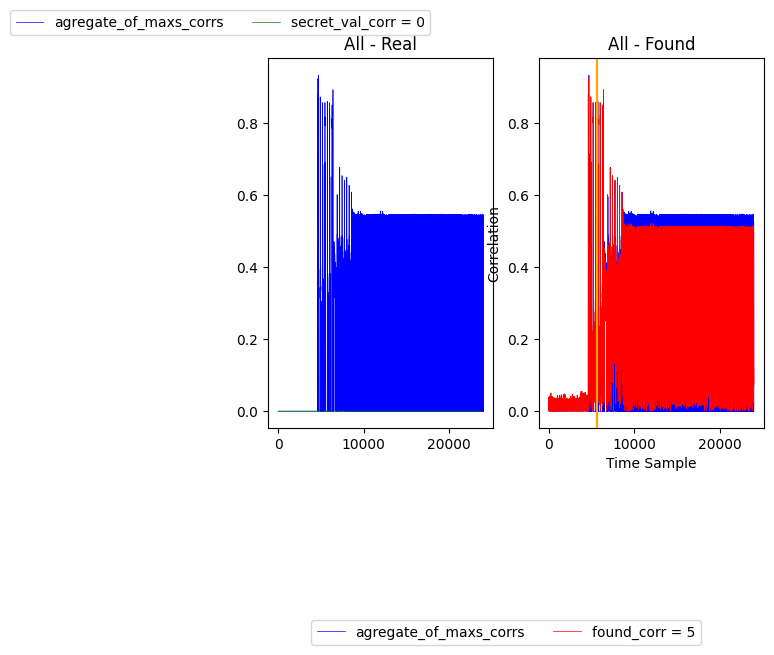

In [72]:
corr_map = abs(np.array(corr2)[:,:])
analyse_corr(corr_map=corr_map, weights=np.array(out)[3:-4], stop_num = 5, maxims_map = None,
                 _index = 0, peak_range = 0.3, show_info=True, mountain_half_dist = 5, level = 3)

11517
 Index of global max: 4637 and global_max_val: 0.9730403116887656


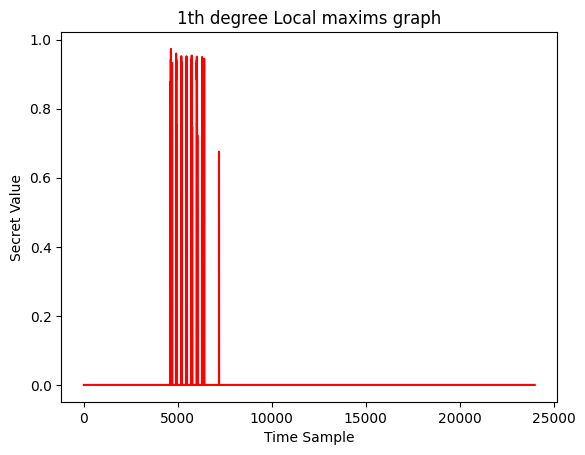

Number of uniques: 3
Number of local maxims: 126
Uniquess: [1, 5, 133]
Local maxims: [1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 133, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


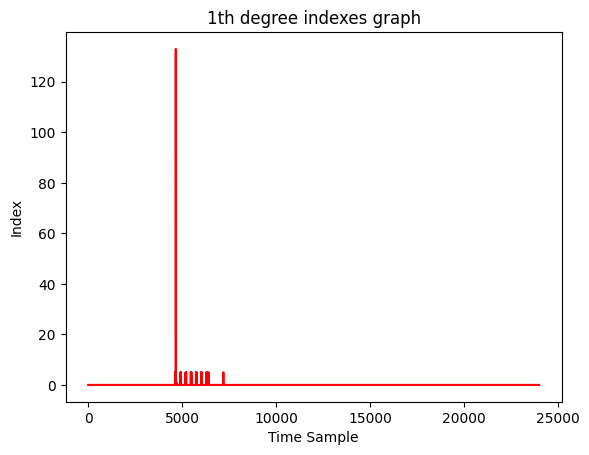

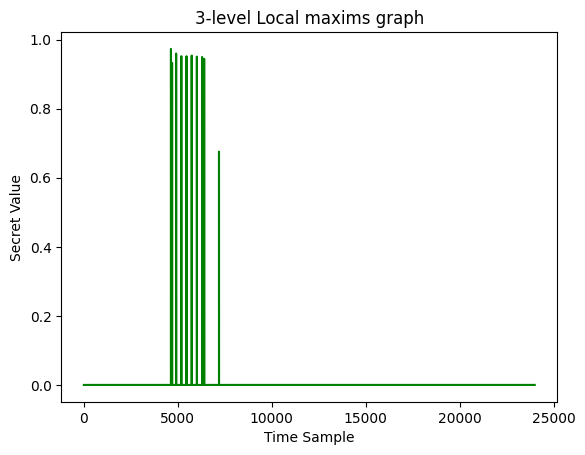

Number of uniques: 2
Number of local maxims: 10
Uniquess: [5, 1]
Local maxims: [5, 1, 5, 5, 5, 5, 5, 5, 5, 5]


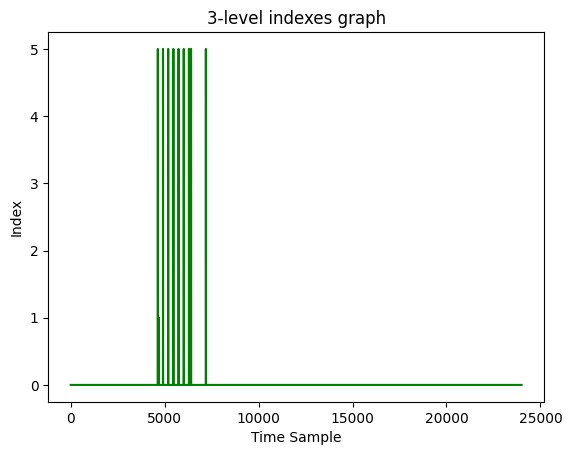

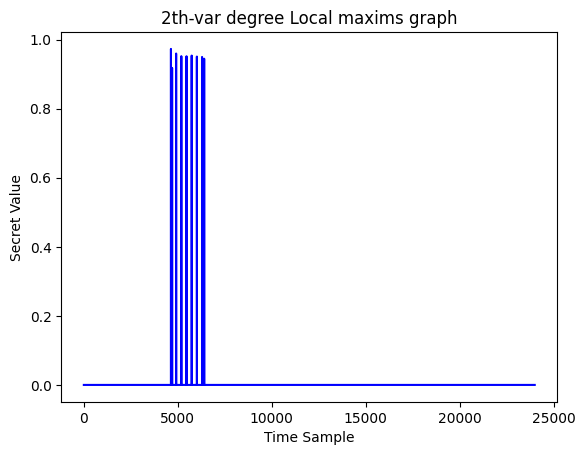

Number of uniques: 2
Number of local maxims: 9
Uniquess: [5, 1]
Local maxims: [5, 1, 5, 5, 5, 5, 5, 5, 5]


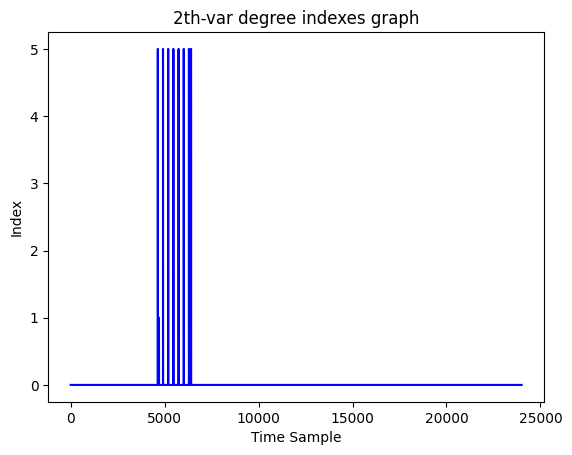

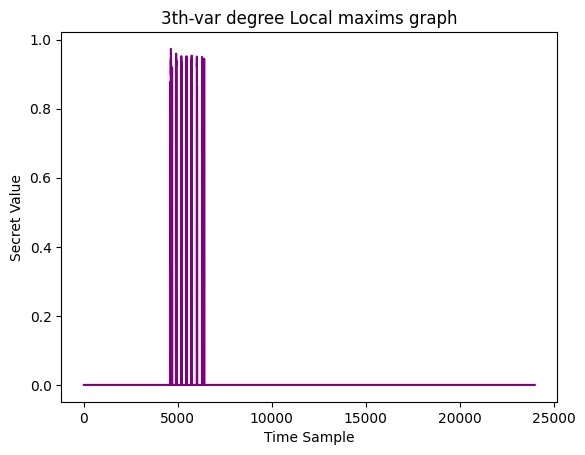

Number of uniques: 2
Number of local maxims: 86
Uniquess: [1, 5]
Local maxims: [1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


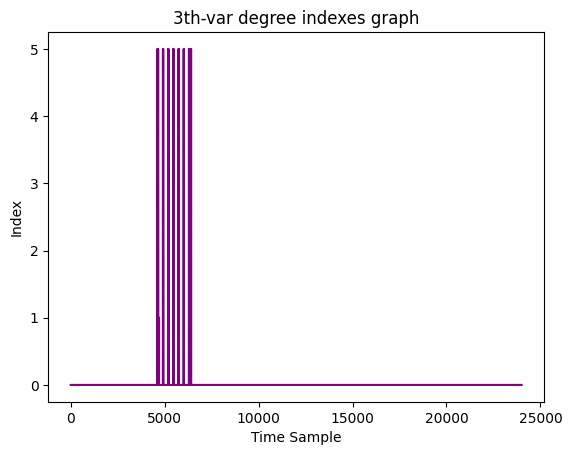

In range 0 - 24000
 Found the soonest secret value is 5, at the time sample 4637, with correlation secret_corr = 0.973


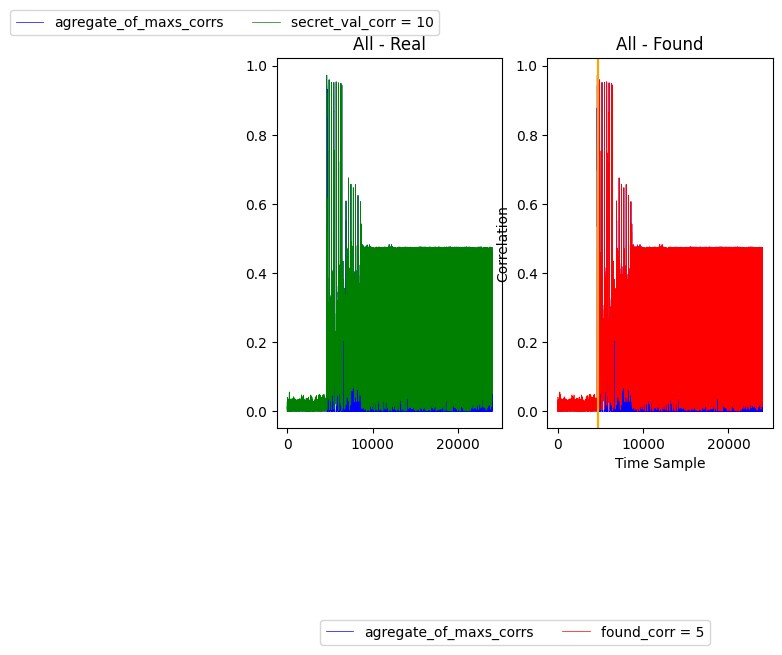

In range 4668 - 24000
 Found the soonest secret value is 1, at the time sample 4698, with correlation secret_corr = 0.918


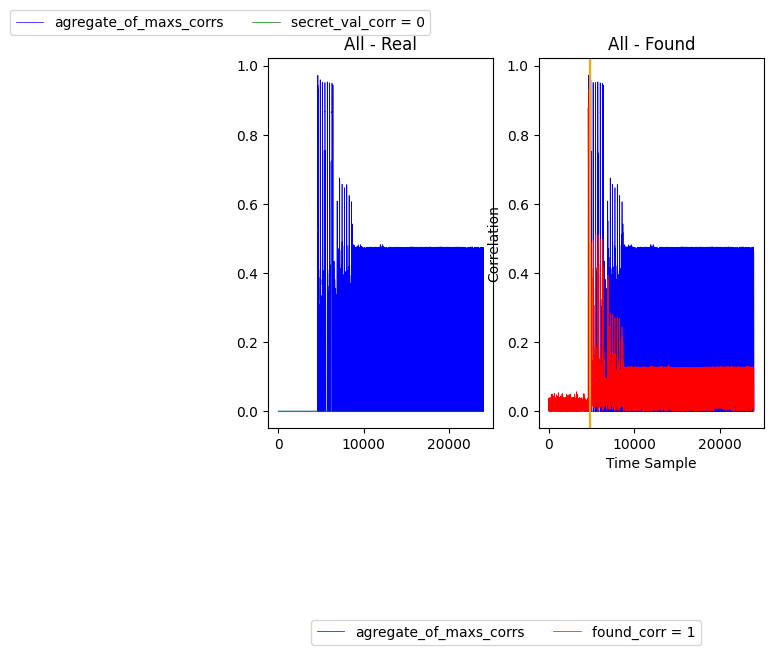

In range 4805 - 24000
 Found the soonest secret value is 5, at the time sample 4913, with correlation secret_corr = 0.960


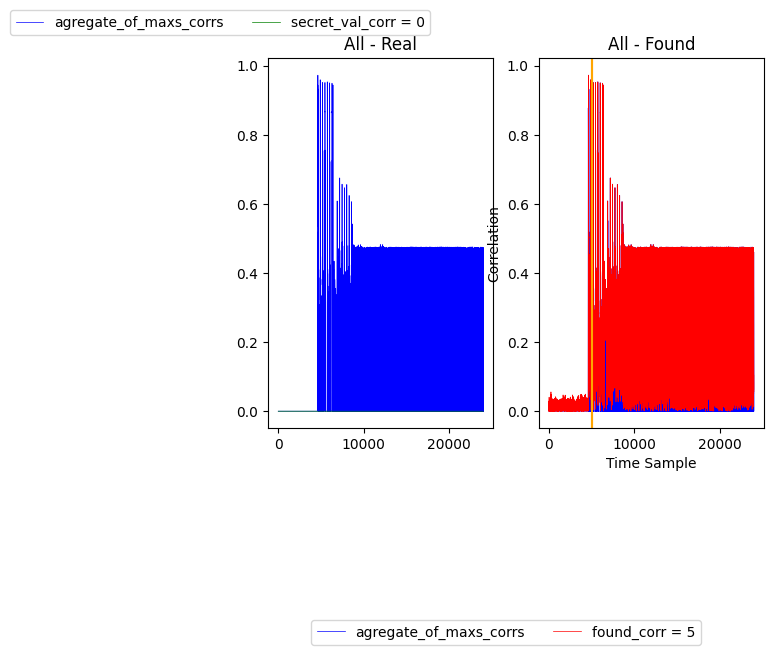

In range 5051 - 24000
 Found the soonest secret value is 5, at the time sample 5189, with correlation secret_corr = 0.952


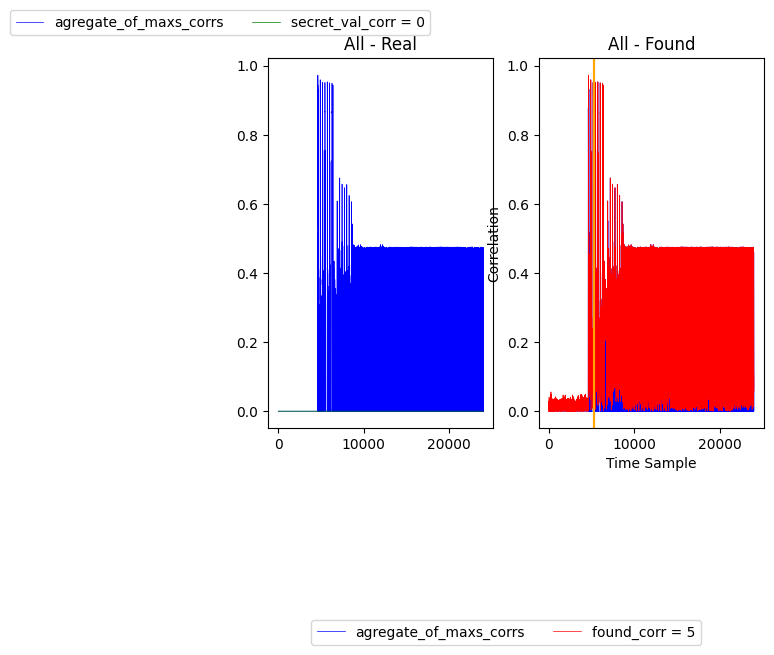

In range 5327 - 24000
 Found the soonest secret value is 5, at the time sample 5465, with correlation secret_corr = 0.952


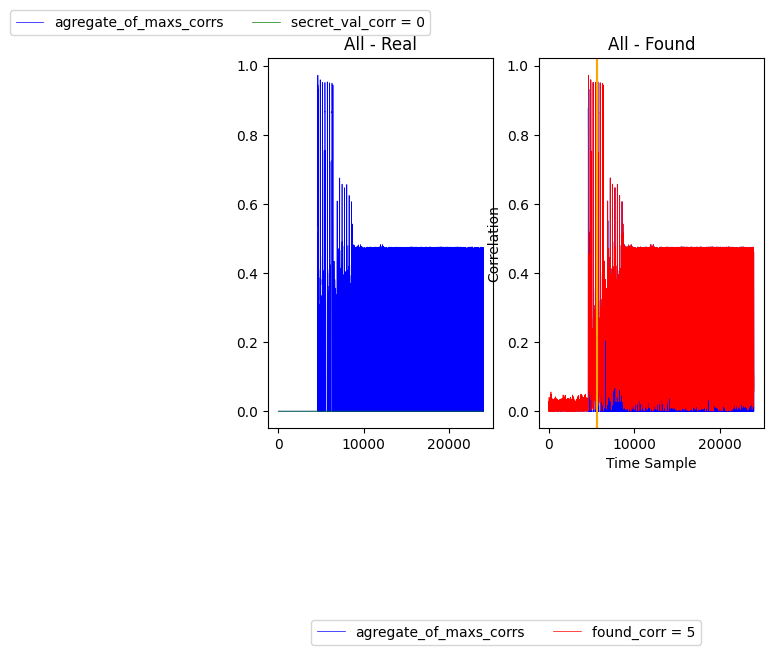

In [51]:
corr_map = abs(np.array(corr1)[:,:])
analyse_corr(corr_map=corr_map, weights=np.array(out)[3:-4], stop_num = 5, maxims_map = None,
                 _index = 0, peak_range = 0.3, show_info=True, mountain_half_dist = 5, level = 3)

### QUANTIZATED ANN CPA, tryout with 2 similar but different CPA algs. 

In [9]:
scope, target, cw_setuper = setup("makefile_dir_basic_quantized_MLP")
time.sleep(10)

⚠️ Changed, firmware config!!!
✔️ Firmware maked, with command cd %s | make CRYPTO_TARGET=%s PLATFORM=%s FIRMWAREPATH=%s SS_VER=%s TARGET=%s> output.txt 2>warnings_new.txt.
INFO: Found ChipWhisperer😍
✔️ INFO: Scope and Target, are set😍
❤️ Target hex: ./makefile_dir_basic_MLP/simpleserial-target-CWLITEARM.hex
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 15963 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 15963 bytes
✔️ Setuper initiated.


Capturing and Analysing the traces::   0%|          | 0/1 [00:00<?, ?it/s]

⚠️ Generating rand_input..


                                Capturing traces:   0%|          | 0/3000 [00:00<?, ?it/s]

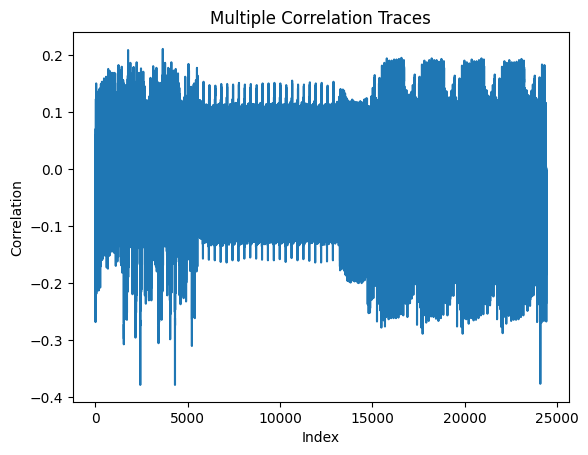

✔️ Saving Rand_input succesfull.
🌍 Saving Secret_weights succesfull.
CWbytearray(b'00 72 16 0a 00 00 00 00 00 00 00 14 00 00 00 00 00 00 00 05 00 00 00 5f 00 c8 00')


Calculating Correlations for the Secret-Key:   0%|          | 0/256 [00:00<?, ?it/s]

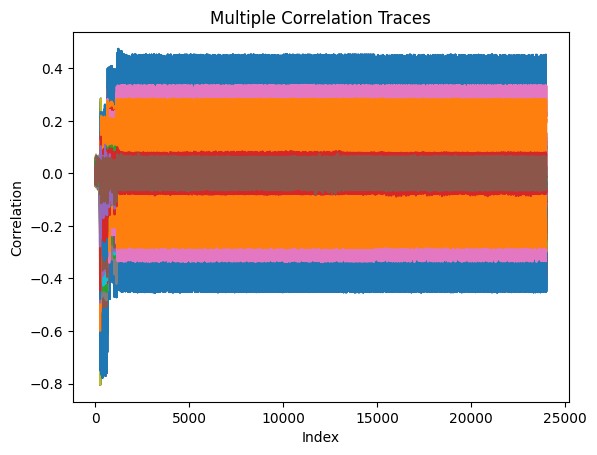

Calculating Correlations for the Secret-Key:   0%|          | 0/256 [00:00<?, ?it/s]

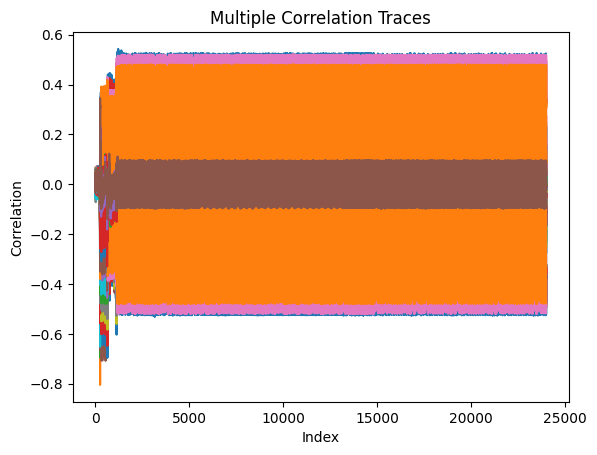

✔️ Scope disconnected.
✔️ Firmware disconnected.


In [14]:
corr1, corr2, rand_input, waves, out = capture_correlate(scope, epochs_list = [3000], ncorr_all1 = None, ncorr_all2 = None, decimate = 1, reverse = False, runName="_722_BasicMLP")

24000
 Index of global max: 249 and global_max_val: 0.8162345949846169


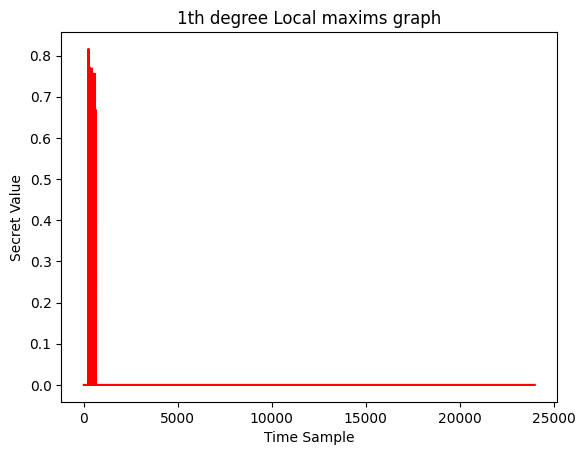

Number of uniques: 2
Number of local maxims: 46
Uniquess: [1, 5]
Local maxims: [1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


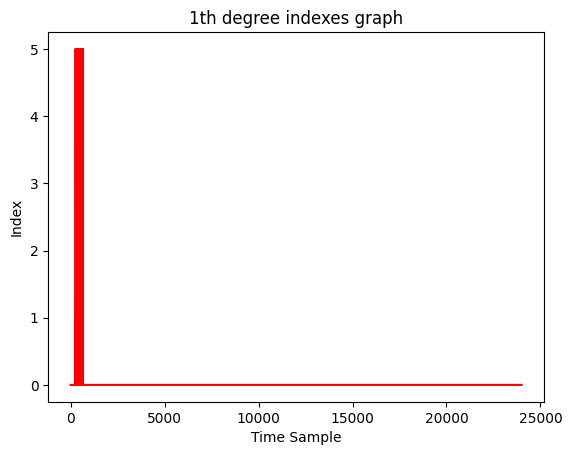

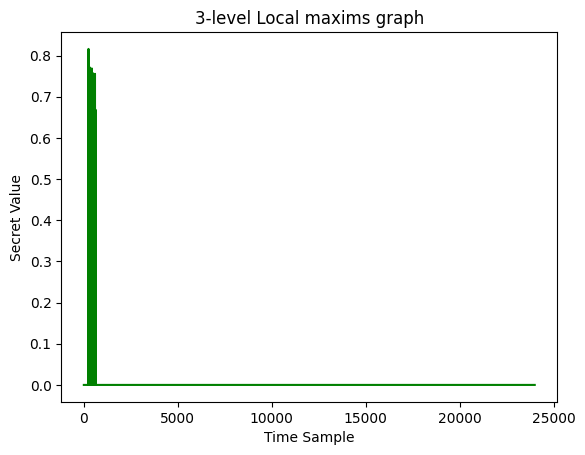

Number of uniques: 2
Number of local maxims: 8
Uniquess: [1, 5]
Local maxims: [1, 5, 5, 5, 5, 5, 5, 5]


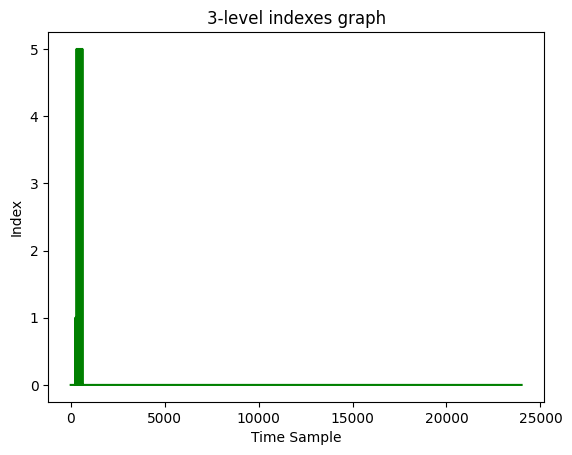

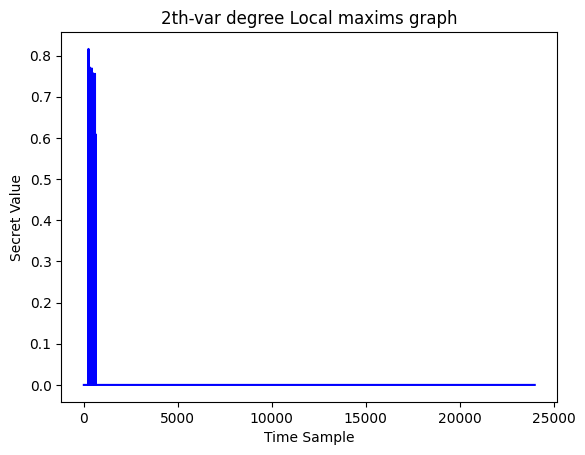

Number of uniques: 2
Number of local maxims: 9
Uniquess: [1, 5]
Local maxims: [1, 5, 5, 5, 5, 5, 5, 5, 5]


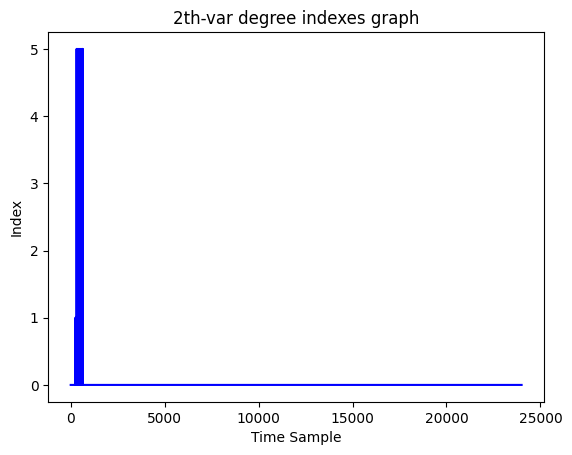

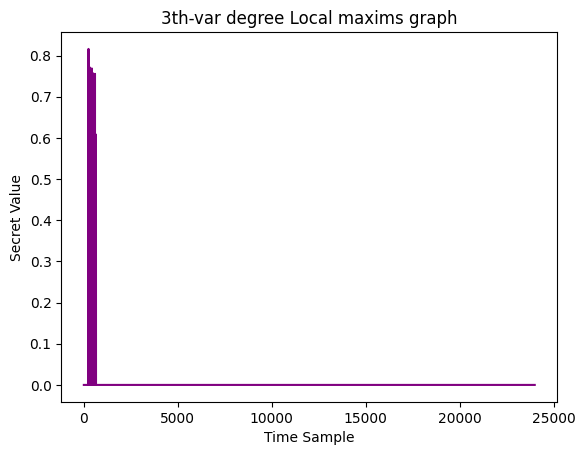

Number of uniques: 2
Number of local maxims: 25
Uniquess: [1, 5]
Local maxims: [1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


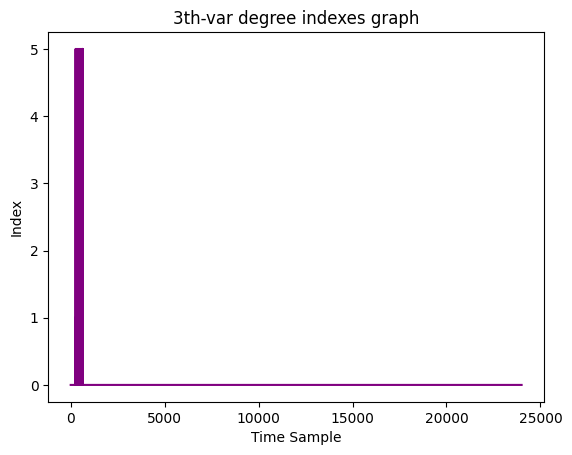

In range 0 - 24000
 Found the soonest secret value is 1, at the time sample 249, with correlation secret_corr = 0.816


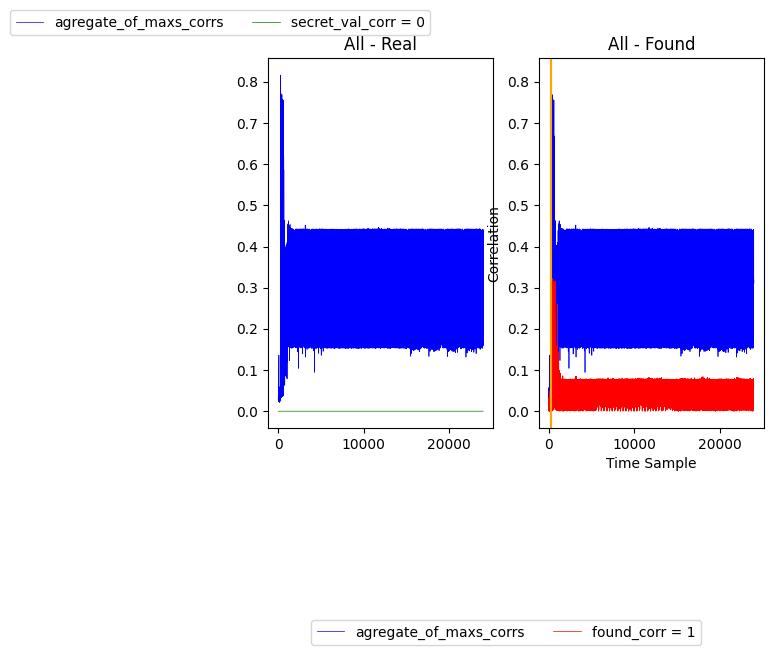

In range 282 - 24000
 Found the soonest secret value is 5, at the time sample 314, with correlation secret_corr = 0.771


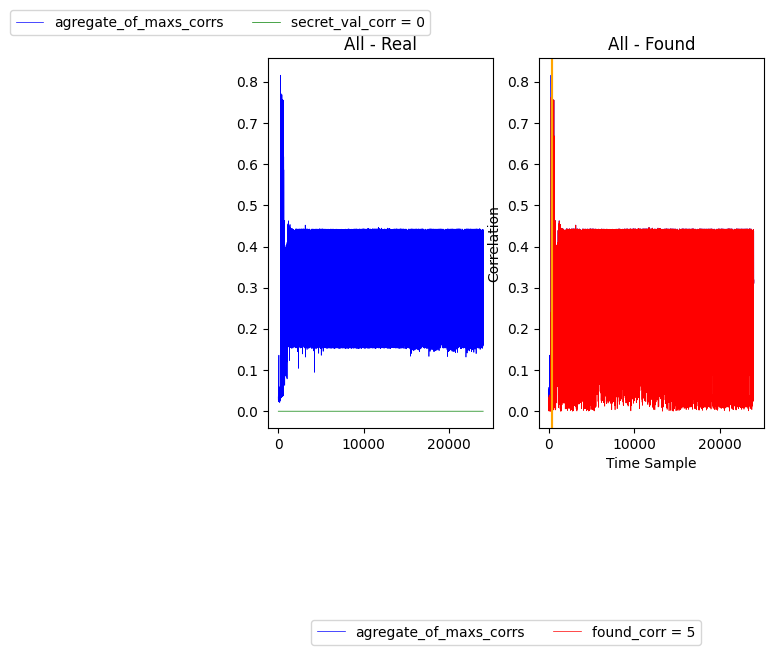

In range 342 - 24000
 Found the soonest secret value is 5, at the time sample 370, with correlation secret_corr = 0.765


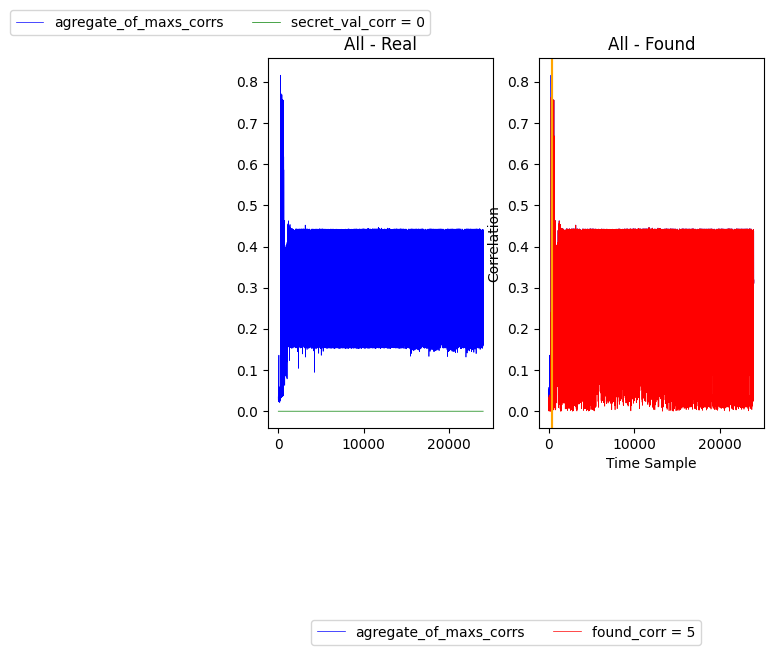

In range 398 - 24000
 Found the soonest secret value is 5, at the time sample 426, with correlation secret_corr = 0.769


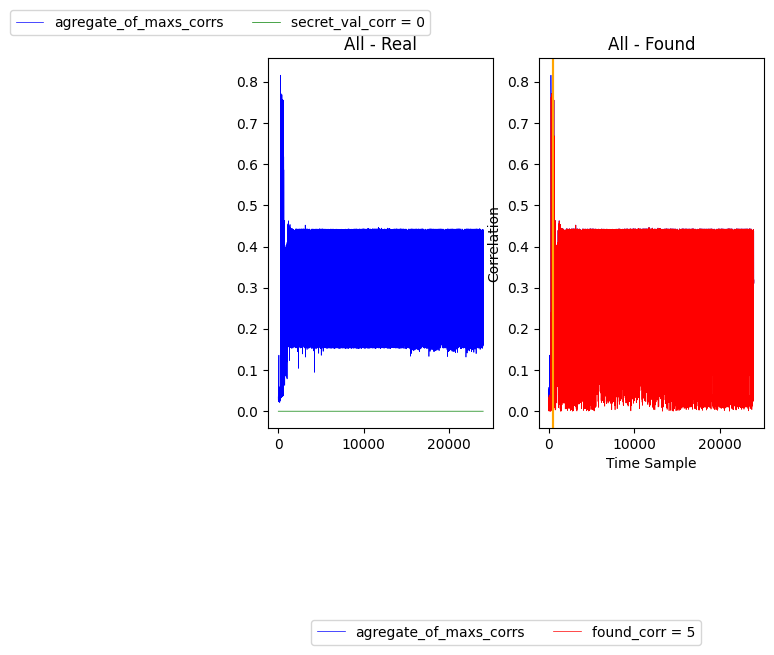

In range 454 - 24000
 Found the soonest secret value is 5, at the time sample 482, with correlation secret_corr = 0.757


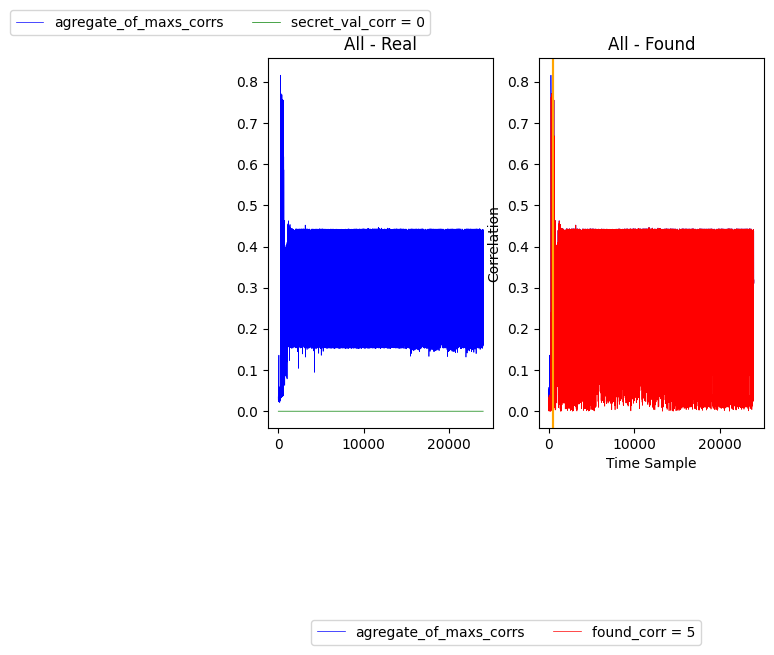

In [42]:
corr_map = abs(np.array(ncorr_all1)[:,:])
analyse_corr(stop_num = 5, maxims_map = None, _index = 0, corr_map: np.ndarray)

## Archive

In [77]:
%run "./Analyser.ipynb"

✔️ The Analyser succesfuly runned.


In [78]:
weights

array([177, 129,   0, 152, 142,   0,  97,  66,   0,  53, 160,   0,  87,
       216,   0,  17, 105,   0, 226,  82,   0])

Calculating Correlations for the Secret-Key:   0%|          | 0/256 [00:00<?, ?it/s]

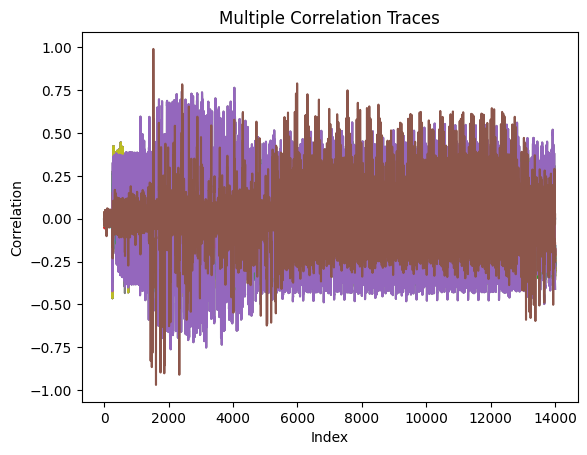

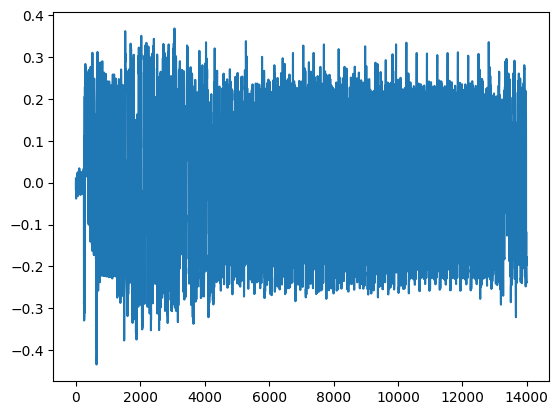

In [79]:
#Analysis
ith_weight = 0
epochs  =  5000
ncorr_all = V2_ANN_CPA_OTS(known_input = rand_input, waves = waves, n_traces = epochs, trace_len = 14000, calc_p_value = False)
plot_mult(np.array(ncorr_all)[:,:], _type = "tmp")
plt.plot(ncorr_all[177])
plt.show()

Calculating Correlations for the Secret-Key:   0%|          | 0/256 [00:00<?, ?it/s]

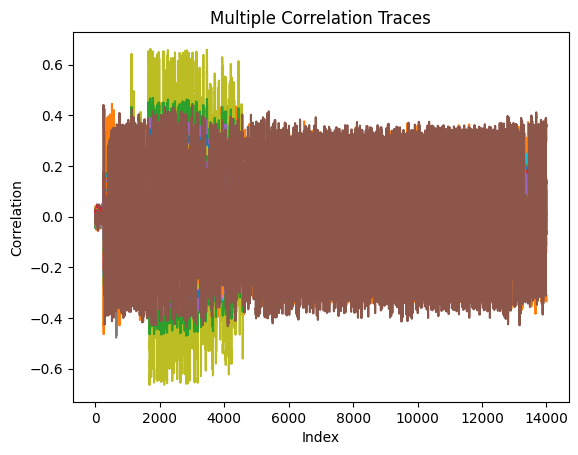

In [26]:
#Analysis
ith_weight = 0
epochs  =  5000
ncorr_all = V2_ANN_CPA_OTS(known_input = rand_input, waves = waves, n_traces = epochs, trace_len = 14000, calc_p_value = False)
plot_mult(np.array(ncorr_all)[:,:], _type = "tmp")
plt.plot(ncorr_all[177])
plt.show()

### Get weights

In [63]:
%run "./Analyser.ipynb"

✔️ The Analyser succesfuly runned.


[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.01108657 0.00741666 0.008679   ... 0.33506068 0.32729733 0.31152184]
 [0.01362667 0.00629412 0.01114756 ... 0.01059773 0.01258632 0.0154629 ]
 ...
 [0.01825064 0.02351102 0.00873667 ... 0.1121432  0.10223093 0.09617812]
 [0.00581129 0.00472941 0.00388187 ... 0.02260998 0.00974858 0.02861844]
 [0.00148902 0.00496238 0.00099493 ... 0.36433888 0.32898034 0.29888986]]
14000
 Index of global max: 1681 and global_max_val: 0.664139754140457


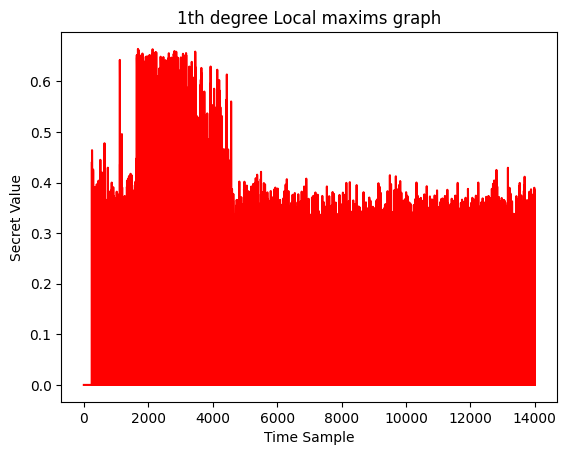

Number of uniques: 56
Number of local maxims: 6381
Uniquess: [255, 1, 2, 136, 177, 128, 127, 206, 49, 50, 130, 179, 178, 78, 77, 65, 207, 191, 73, 109, 25, 155, 126, 129, 63, 39, 202, 81, 217, 185, 249, 153, 19, 101, 71, 237, 167, 51, 105, 111, 213, 75, 141, 251, 242, 201, 37, 183, 145, 205, 147, 233, 115, 40, 23, 219]
Local maxims: [255, 255, 1, 1, 1, 1, 1, 1, 2, 2, 255, 1, 1, 1, 1, 1, 1, 1, 255, 1, 1, 1, 1, 1, 255, 255, 1, 1, 1, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 1, 1, 2, 255, 1, 1, 1, 1, 1, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 1, 255, 255, 255, 255, 255, 1, 1, 1, 1, 255, 1, 1, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 1, 1, 1, 1, 255, 1, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 1, 255, 255, 255, 255, 255, 255, 255, 255, 1, 1, 1, 136, 1, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 1, 1, 1, 255, 255, 255, 255, 255, 255, 255, 2

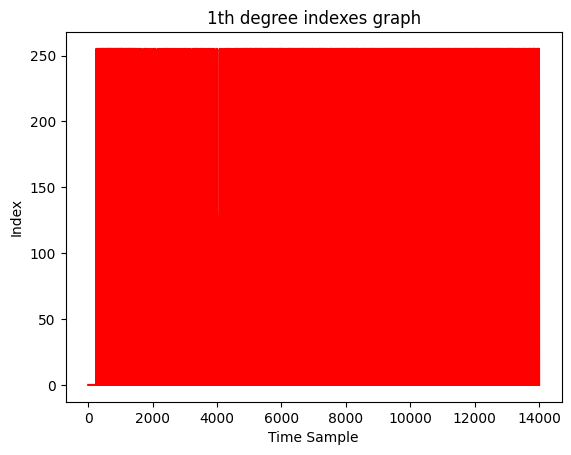

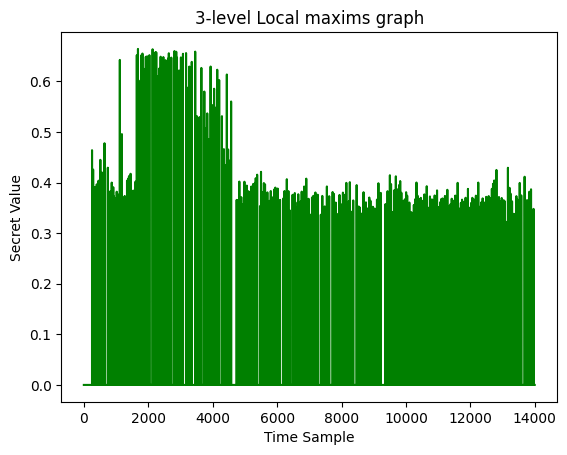

Number of uniques: 4
Number of local maxims: 276
Uniquess: [1, 255, 177, 128]
Local maxims: [1, 255, 255, 255, 255, 1, 1, 255, 1, 255, 1, 255, 177, 1, 255, 255, 255, 255, 255, 255, 255, 128, 128, 255, 255, 255, 1, 128, 255, 1, 255, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 1, 128, 128, 128, 128, 255, 1, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 1, 1, 255, 255, 255, 255, 255, 255, 255, 1, 255, 255, 255, 255, 1, 255, 255, 255, 255, 255, 1, 255, 255, 255, 255, 255, 255, 255, 255, 1, 1, 255, 255, 255, 255, 255, 255, 255, 255, 1, 255, 255, 255, 255, 1, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

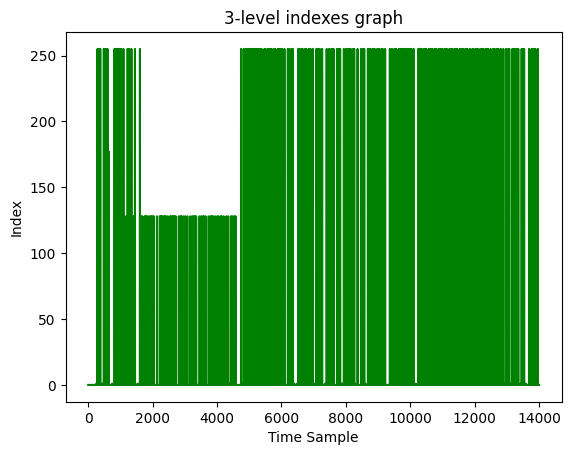

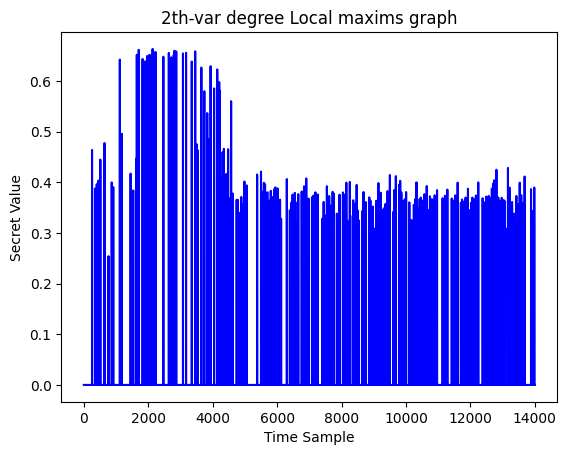

Number of uniques: 4
Number of local maxims: 229
Uniquess: [1, 177, 255, 128]
Local maxims: [1, 1, 1, 1, 1, 177, 255, 255, 255, 128, 128, 255, 1, 128, 128, 128, 128, 128, 128, 128, 128, 128, 1, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 1, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 1, 1, 128, 1, 255, 128, 128, 1, 128, 255, 255, 1, 255, 255, 255, 1, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 1, 255, 255, 255, 1, 255, 1, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 1, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 1, 255, 255, 255, 255, 1, 255, 255, 255, 1, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 1, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2

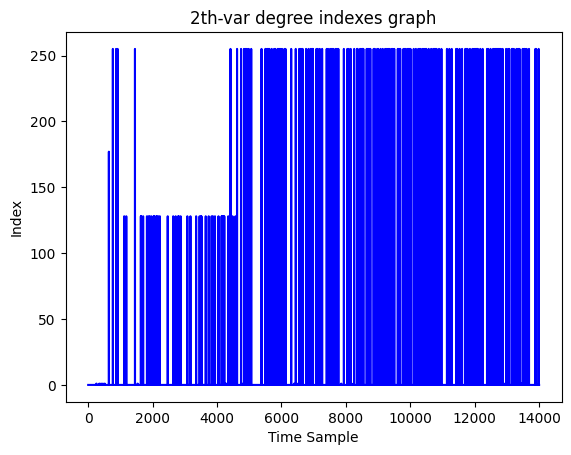

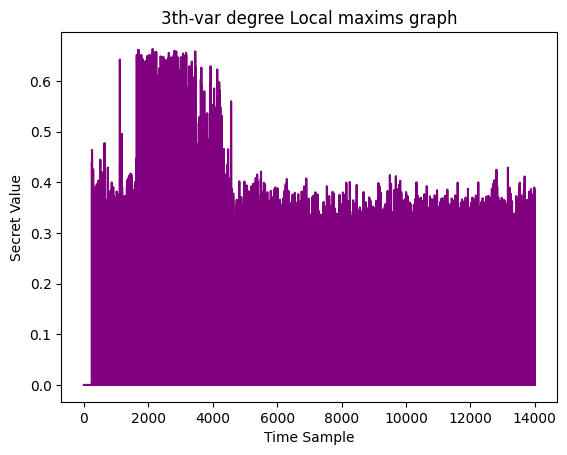

Number of uniques: 56
Number of local maxims: 5116
Uniquess: [255, 1, 2, 136, 177, 128, 127, 206, 49, 50, 130, 179, 178, 78, 77, 65, 207, 191, 73, 109, 25, 155, 126, 129, 63, 39, 202, 81, 217, 185, 249, 153, 19, 101, 71, 237, 167, 51, 105, 111, 213, 75, 141, 251, 242, 201, 37, 183, 145, 205, 147, 233, 115, 40, 23, 219]
Local maxims: [255, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 255, 1, 1, 1, 1, 1, 255, 255, 1, 255, 255, 255, 255, 255, 255, 255, 255, 1, 1, 2, 255, 1, 1, 1, 1, 1, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 1, 255, 1, 1, 1, 255, 1, 1, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 1, 1, 1, 1, 255, 1, 255, 255, 255, 255, 255, 255, 255, 255, 255, 1, 255, 255, 255, 255, 1, 1, 1, 136, 1, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 1, 1, 1, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 177, 177, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255

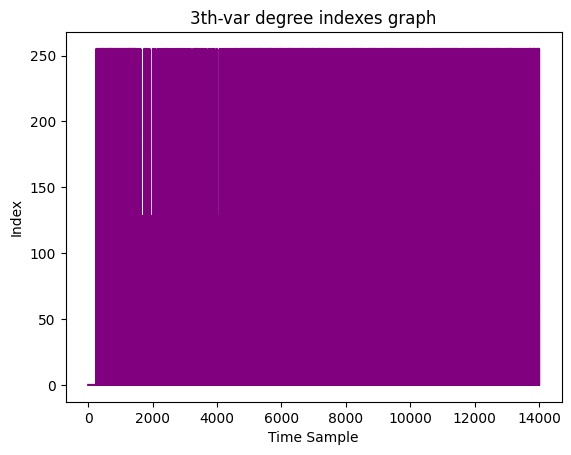

In range 0 - 14000
 Found the soonest secret value is 1, at the time sample 255, with correlation secret_corr = 0.464


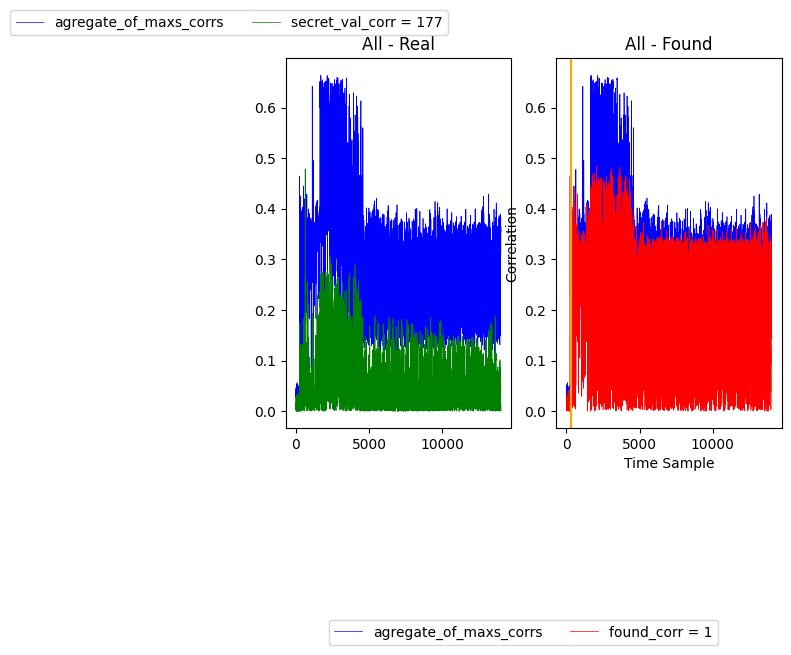

In range 300 - 14000
 Found the soonest secret value is 1, at the time sample 346, with correlation secret_corr = 0.388


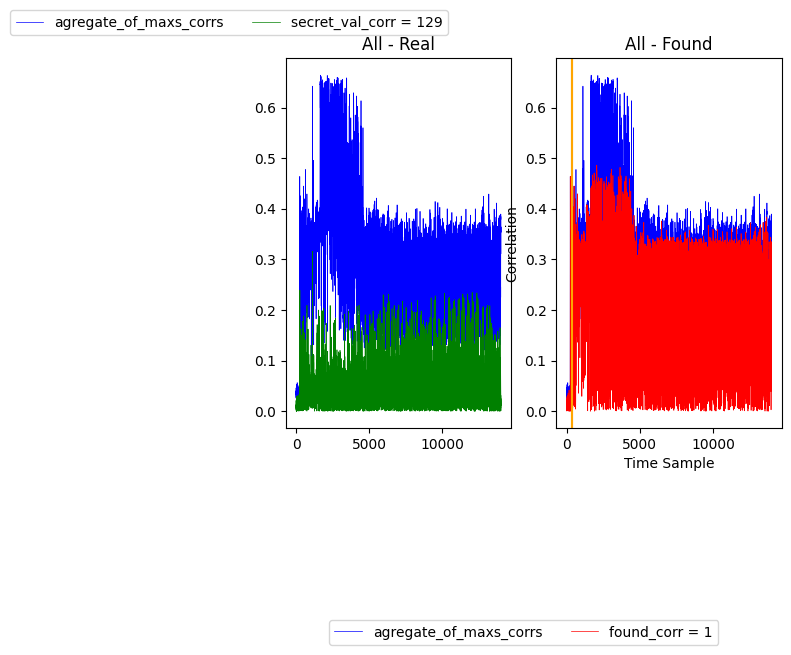

In range 373 - 14000
 Found the soonest secret value is 1, at the time sample 401, with correlation secret_corr = 0.396


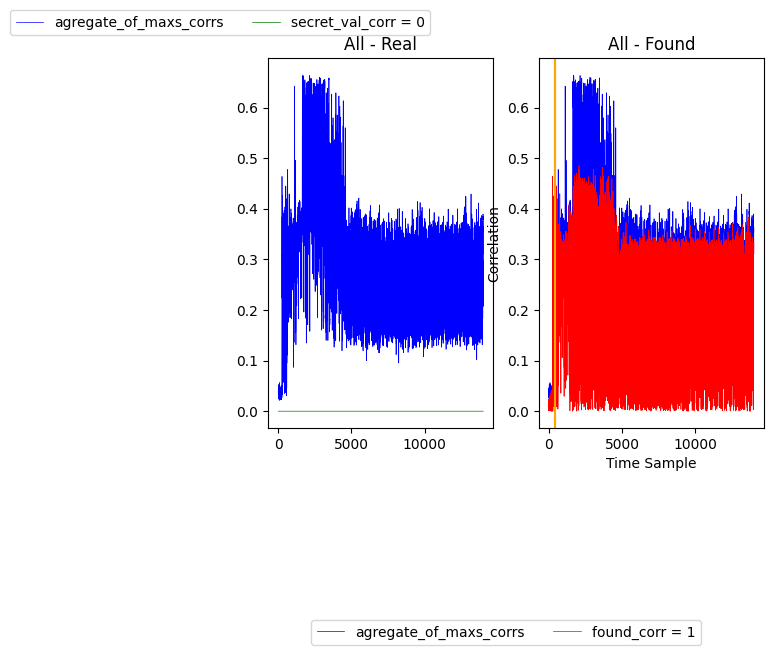

In range 429 - 14000
 Found the soonest secret value is 1, at the time sample 457, with correlation secret_corr = 0.404


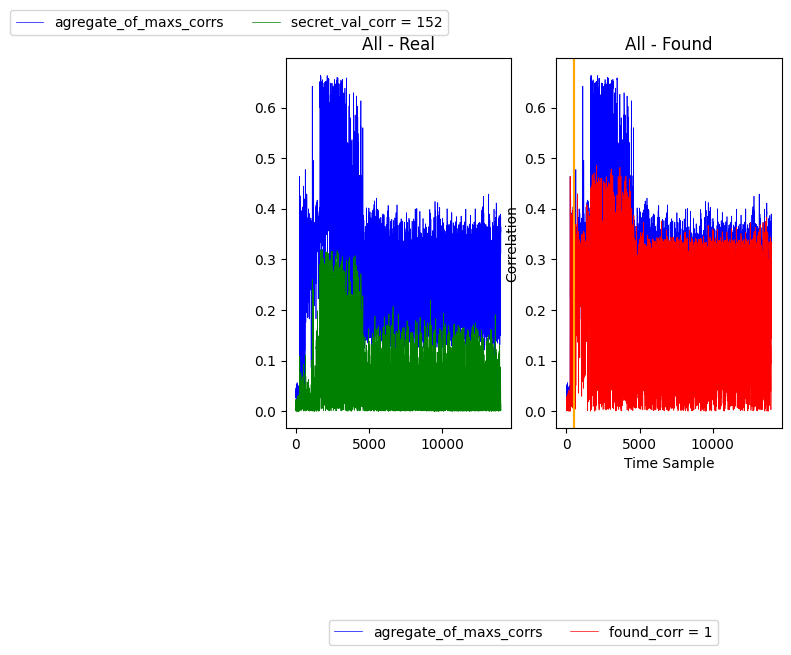

In range 485 - 14000
 Found the soonest secret value is 1, at the time sample 513, with correlation secret_corr = 0.445


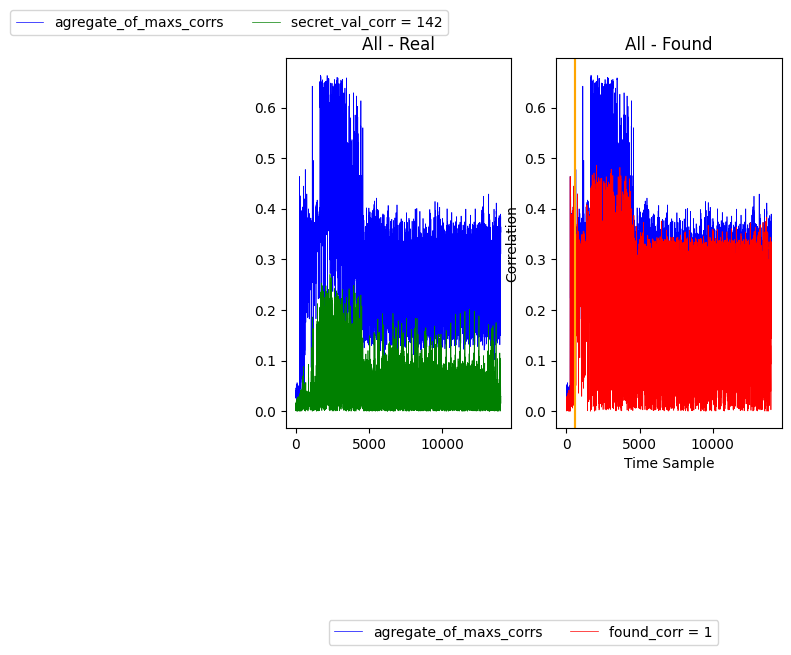

In [64]:
stop_num = 5
maxims_map = None
index = 0
maxims_map = None
corr_map = abs(np.array(ncorr_all))
print(corr_map)
#secret_weight = []
#for i in range(50):
#    secret_weight.append(i)
for secret in weights:
    secret_value, time_sample, correlation, localMax_vector, colmn_maxVector, nextIndex, maxims_map  = get_weight(corr_map,
                                                                                                                 peak_range = 0.5,
                                                                                                                 show_info=True,
                                                                                                                 lastIndex=index,
                                                                                                                 map_2dgrMaxs=maxims_map,
                                                                                                                 mountain_half_dist = 5,
                                                                                                                level = 3)

    index = nextIndex
    figure, axis = plt.subplots(1, 2)
    # Comparison to real correlation
    axis[0].plot(colmn_maxVector, color='b', label='agregate_of_maxs_corrs', linewidth=0.5)
    axis[0].plot(corr_map[secret], color='g', label=f'secret_val_corr = {secret}', linewidth=0.5)
    #axis[0].legend(loc='upper right')
    axis[0].legend(bbox_to_anchor=(0.75, 1.15), ncol=2)
    axis[0].set_title("All - Real")
    plt.xlabel("Time Sample")
    plt.ylabel("Correlation")
    plt.axvline(x = index, color = 'orange')

    # Comparison to found correlation
    axis[1].plot(colmn_maxVector, color='b', label='agregate_of_maxs_corrs', linewidth=0.5)
    axis[1].plot(corr_map[secret_value], color='r', label=f'found_corr = {secret_value}', linewidth=0.5)
    #axis[1].legend(loc='upper right')
    axis[1].legend(bbox_to_anchor=(0.75, -0.5), ncol=2)
    axis[1].set_title("All - Found")
    plt.axvline(x = index, color = 'orange')

    #figure.savefig(f'{name}_correlation.png')

    stop_num -= 1
    if stop_num == 0:
        break
    plt.show()
    last_found_indx = time_sample